# **MLMOL Final Assignment: Comparison of Neural Network Architectures on Predicting Biological Activity of Small Molecules**
### Johan Rytved

In [ ]:
rand_state_of_choice = 18 # Sets the random state for the train-test-splits, torch models and random undersampling of the majority class.

## **Imports & Settings**

In [ ]:
# Nice colors for plots
blue = "#001965"
grey = "#f8f8f8"
green = "#6ed47c"
red = "#cf4444"
darkred = "#e31010"
orange = "#f7cc20"
lightblue = "#3f9ff2"

In [ ]:
%%capture
!pip install rdkit torch_geometric mols2grid deepchem

In [ ]:
#MISC. IMPORTS
import pandas as pd, matplotlib.pyplot as plt, numpy as np, rdkit
from tqdm.auto import tqdm
from collections import Counter
import math
from IPython.core.display import display, HTML
import os
import mols2grid
import deepchem as dc
#RDKIT IMPORTS
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges

#TORCH IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pad_sequence
#from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torch.utils.data import TensorDataset, DataLoader, random_split

#PYG IMPORTS

import torch_geometric
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GraphConv
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.utils import to_networkx
from torch_geometric.nn.norm import GraphNorm

#SKLEARN IMPORT
from sklearn.metrics import multilabel_confusion_matrix, RocCurveDisplay, roc_auc_score, recall_score, f1_score, precision_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale, LabelBinarizer
from sklearn.model_selection import train_test_split

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
# Seeding library with the random state
torch.manual_seed(rand_state_of_choice)
np.random.seed(rand_state_of_choice)

**Setup of directories**

In [ ]:
# make directory for the dataset
! mkdir datasets
! wget -P ./datasets https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz

--2024-01-21 20:04:07--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.112.65, 52.219.117.162, 52.219.112.249, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.112.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122925 (120K) [application/x-gzip]
Saving to: ‘./datasets/tox21.csv.gz’

tox21.csv.gz        100%[===================>] 120.04K  --.-KB/s    in 0.03s   

2024-01-21 20:04:07 (3.46 MB/s) - ‘./datasets/tox21.csv.gz’ saved [122925/122925]



## **Utility Functions**

In [ ]:
def add_title(title: str):
  """Easy way to add a super-title to any MPL-plot with consistent fontsize and weight"""
  plt.suptitle(title, fontsize = 18, fontweight = "bold")

In [ ]:
def map_atoms_in_dataset(smiles):

  """
  Iterates over a SMILES column from a dataset to compute:
    1) unique_atoms_map: a dictionary mapping atom-types in the dataset to an integer
    2) max_atoms_in_dset: the largest number of atoms in a molecule in the dataset (including H's)
    3) max_unique_atoms_in_dset: the length of (unique_atoms_map); how many unique atoms are in the dataset?
  """

  max_atoms_in_dset = 0
  unique_atoms_map = {}
  atom_hash_index = 0

  for smile in tqdm(smiles):
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)

    atoms_in_mol = 0

    for atom in mol.GetAtoms():
      atoms_in_mol +=1
      atomic_num = atom.GetAtomicNum()

      if atomic_num in unique_atoms_map:
        continue
      else:
        unique_atoms_map[atomic_num] = atom_hash_index
        atom_hash_index += 1

    if atoms_in_mol > max_atoms_in_dset:
      max_atoms_in_dset = atoms_in_mol

  return unique_atoms_map, max_atoms_in_dset

In [ ]:
def EdgeIndexFromSmiles(smiles):

  """
  Computes the edge-index matrix to describe the connectivity of a molecule.
  Creates an edge in each direction for a bond in the molecule (to make the graph undirected)
  Also adds self-loops by adding self-directed edges for all nodes.
  """

  mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
  atom_indexes = [atom.GetIdx() for atom in mol.GetAtoms()]

  # Making all non-self directed edges
  begAtoms = [i.GetBeginAtomIdx()for i in mol.GetBonds()]
  endAtoms = [i.GetEndAtomIdx()for i in mol.GetBonds()]

  # Making all edges non-directed (edges go both ways between any two nodes), and also adding self-directed edges
  topRow = begAtoms + endAtoms + atom_indexes
  botRow = endAtoms + begAtoms + atom_indexes

  edge_index = torch.tensor([topRow, botRow], dtype=torch.long)

  return edge_index

In [ ]:
def CreatePYGData(node_feature_matrix, edge_index_matrix, y, edge_feature_matrix = None):

  """
  Creates a PyTorch Geometric (PYG) DataObject from a node-feature matrix and an edge_index_matrix.
  Also has the possibility to add an edge-feature matrix if edge-features are to be included. This is not relevant for GCNConv.
  """

  n_nodes = node_feature_matrix.shape[0]

  node_feature_matrix = torch.tensor(node_feature_matrix, dtype = torch.float32)  # Convert node features to a PyTorch-tensor.

  y = y[np.newaxis]                                                               # Add Batch Axis to Y. Prerequisite for doing batching.
  y = torch.tensor(y, dtype = torch.float32)                                      # Convert y to a PyTorch-tensor.

  if edge_feature_matrix is not None:
    data = Data(x=node_feature_matrix, edge_index = edge_index_matrix, edge_attr = edge_feature_matrix, y = y, num_nodes = n_nodes)
  else:
    data = Data(x=node_feature_matrix, edge_index = edge_index_matrix, y = y, num_nodes = n_nodes)

  return data

In [ ]:
def compute_classification_metrics(y_true: torch.tensor, y_pred: torch.tensor, return_df = False, colnames = None, style = False, title = False):
  """
  Computes accuracy, precision, recall, F1 score, specificity from multi-class classification predictions and labels.
  """

  def color_gradient(val):
    color = f'rgb({int(255 * (1 - val))}, {int(255 * val)}, 0)'
    return f'background-color: {color}'

  n_tasks = y_true.shape[1]

  cfm = multilabel_confusion_matrix(y_true, y_pred)

  # Precision, recall, F1-scores can be directly calculated with sklearn
  precision = precision_score(y_true, y_pred, average = None)
  recall = recall_score(y_true, y_pred, average = None)
  f1 = f1_score(y_true, y_pred, average = None)

  # Accuracy and specificity a are not implemented for multi-class tasks, so I'll calculate those from the CFM.

  accuracy, specificity  = np.zeros(n_tasks), np.zeros(n_tasks)

  for class_idx in np.arange(n_tasks):

    class_cfm = cfm[class_idx]
    tn, fp, fn, tp = class_cfm.ravel()

    _accuracy = (tp+tn) / (tp+tn+fp+fn)
    _specificity = tn / (fp+tn)

    accuracy[class_idx] = _accuracy
    specificity[class_idx] = _specificity

  if return_df:
    metric_names = ["Accuracy", "Precision", "Recall", "F1", "Specificity"]
    stack = np.vstack([accuracy, precision, recall, f1, specificity])
    df = pd.DataFrame(stack, columns = colnames, index = metric_names).round(decimals=2)

    if not style:
      return df
    else:
      styled_df = df.style \
          .set_caption(title) \
          .applymap(color_gradient) \
          .format('{:.2f}') \
          .set_table_styles([{
          'selector': 'caption',
          'props': [
            ('color', 'black'),
            ('font-size', '24px'),
            ('font-weight', 'bold')
            ]
          }])
      return styled_df
  else:
    return accuracy, precision, recall, f1, specificity

In [ ]:
def binarize_predictions(predictions, threshold = 0.5):
  """Binarizes predictions at a certain threshold"""
  return (predictions > threshold).float()

In [ ]:
def GenerateConformer(molecule: rdkit.Chem.rdchem.Mol):

  """Generate conformers for molecule"""

  molecule = Chem.AddHs(molecule)
  ps = AllChem.ETKDGv2()
  AllChem.EmbedMolecule(molecule, ps)

  if molecule.GetNumConformers() == 0: # If conformer generation fails the first time around, try to start from random coordinates
    ps.useRandomCoords = True
    AllChem.EmbedMolecule(molecule, ps)

  if molecule.GetNumConformers() == 0:
    raise ValueError(f"Failed to generate conformer for mol with SMILES: {Chem.MolToSmiles(molecule)}")

  return molecule

In [ ]:
def GetTensorCoulombMatrix(molecule, pad_up_to = None, skipConformerGeneration = False):
  """
  Generates a Coulomb Matrix as tensor from a rdkit.Chem.rdchem.Mol or SMILES string.

  Arguments:
    molecule: rdkit.Chem.rdchem.Mol or SMILES-string (str)
    pad_up_to: If not None, the output Tensor is padded up to this number along the 1st dimension.

  Returns:
    A torch.tensor of size (n_atoms x atoms) if pad_up_to = None
    Otherwise returns a tensor of size (n_atoms x pad_up_to)

  """

  assert type(molecule) in [str, rdkit.Chem.rdchem.Mol], "Molecule is neither an rdkit mol or string"

  if type(molecule) == str:
    molecule = Chem.MolFromSmiles(molecule)

  if not skipConformerGeneration:
    molecule = Chem.AddHs(molecule)

    ps = AllChem.ETKDGv2()
    AllChem.EmbedMolecule(molecule, ps)

    if molecule.GetNumConformers() == 0: # If conformer generation fails the first time around, try to start from random coordinates
      ps.useRandomCoords = True
      AllChem.EmbedMolecule(molecule, ps)

  try:
    cmat = rdMolDescriptors.CalcCoulombMat(molecule)
    cmat_as_tensor = torch.vstack([torch.tensor(row, dtype = torch.float) for row in cmat])

  except:
    raise ValueError("Failed to generate coulomb matrix :(")

  if pad_up_to is not None:
    width = cmat_as_tensor.shape[1]
    needed_pad = pad_up_to - width
    return torch.nn.functional.pad(input = cmat_as_tensor, pad = (0, needed_pad))

  else:
    return cmat_as_tensor


## **Plotting Functions**

In [ ]:
def plot_loss_curve(t_loss, v_loss, c1, c2, ylab, title):
  fig, ax = plt.subplots(figsize = (15,5))
  add_title(title)
  ax.set_ylabel(ylab)
  ax.set_xlabel("Epoch")
  ax.plot(t_loss, color = c1, label = "Train Loss")
  ax.plot(v_loss, color = c2, label = "Validation Loss")
  ax.legend()

In [ ]:
def plot_cfms(cfms, class_names, suptitle ="Fig. X:"):

  n_sets = len(cfms)
  n_classes = len(cfms[0])

  fig, ax = plt.subplots(n_sets, n_classes, figsize = (18, 7))

  for row, _set in enumerate(cfms):
    for col, subclass in enumerate(_set):

      if n_sets > 1:
        ConfusionMatrixDisplay(subclass).plot(ax = ax[row][col])
        ax[row][col].set_title(target_names[col], fontweight = "bold")

      else:
        ConfusionMatrixDisplay(subclass).plot(ax = ax[col])
        ax[col].set_title(target_names[col], fontweight = "bold")

  add_title(suptitle)
  plt.tight_layout()

In [ ]:
def makefig1():
  task_value_counts = tasks.sum(axis = 0).values
  negative_value_counts = datalen - task_value_counts
  no_activities_counts = tasks.sum(axis = 1).value_counts().values
  no_activities_labels = tasks.sum(axis = 1).value_counts().index.values
  fig, ax = plt.subplot_mosaic("AB;DD", figsize = (15,5))

  # Plot of Activities Per Target
  ax["A"].bar(target_names, task_value_counts, color = blue)
  ax["A"].set_title("A) Count of Molecules with Activity Against Target")
  ax["A"].set_xlabel("Target")
  ax["A"].set_ylabel("Count")

  # Plot of No. of Activities Per Molecule
  ax["B"].bar(no_activities_labels, no_activities_counts, color = blue)
  ax["B"].set_xlabel("Number of activities")
  ax["B"].set_ylabel("Count")
  ax["B"].set_title("B) Count of Unique Activities per. Molecule")

  # Plot of Positive and Negative Classes
  ax["D"].bar(np.arange(n_tasks)-0.25, task_value_counts, color = blue, width = .25, label = "Positive Classes")
  ax["D"].bar(np.arange(n_tasks)+0.25, negative_value_counts, color = lightblue, width = .25, label = "Negative Classes")
  ax["D"].set_xticks(range(n_tasks))
  ax["D"].set_xticklabels(target_names)
  ax["D"].legend()
  ax["D"].set_title("C) Number of positive vs negative classes for each target")

  add_title("Fig. 1: Preliminary Data Analysis of Tox21")
  plt.tight_layout()

In [ ]:
def makefig2():
  spaced_nums = np.linspace(0, 1, 1000)  # Equally spaced numbers in range [0, 1]
  mse_true_label_1 = np.sqrt((1 - spaced_nums)**2)
  logloss_true_label_1 = -(np.log(spaced_nums))
  fig, ax = plt.subplots(figsize = (15,5))
  ax.plot(spaced_nums, mse_true_label_1, label = "MSE")
  ax.plot(spaced_nums, logloss_true_label_1, label ="BCE / Log Loss")
  ax.legend()
  add_title("Fig. 2: BCE / Log Loss vs MSE for Classification (True Label = 1)")
  ax.set_xlabel("Predicted Value")
  ax.set_ylabel("Loss")

In [ ]:
def make_roc_curves(y_true, y_pred, title, class_names, color = "red"):

  n_classes = len(class_names)

  label_binarizer = LabelBinarizer().fit(y_true)
  labels_binarized = label_binarizer.transform(y_true)

  fig, ax = plt.subplots(1,n_tasks, figsize = (20,5))

  for i in range(n_classes):

    class_id = i

    RocCurveDisplay.from_predictions(
        labels_binarized[:, class_id],
        y_pred[:, class_id],
        color=color,
        ax = ax[i]
    )

    ax[i].set_xlabel("FPR")
    ax[i].set_ylabel("TPR / Sensitivity / Recall")
    ax[i].axis("square")
    ax[i].set_title(f"OvA ROC for {class_names[i]}")
    ax[i].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label = "Reference", color = green, linestyle = "dashed")
    ax[i].legend()

  add_title(title)

In [ ]:
def display_side_by_side(dfs:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
    """
    output = ""
    for df in dfs:
      if type(df) == pd.io.formats.style.Styler:
        output += df.set_table_attributes("style='display:inline'")._repr_html_()
        output += tablespacing * "\xa0"
      else:
        output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
        output += tablespacing * "\xa0"

    display(HTML(output))

In [ ]:
def makef1compfig():
  fig, ax = plt.subplots(1, n_tasks, figsize = (30,5))

  dataset_names = ("Train", "Test", "Val")

  for i, dataset in enumerate([dnn_train_f1, dnn_test_f1, dnn_val_f1]):
    for cls in range(5):
      ax[cls].plot(dataset[:, cls], label = dataset_names[i])
      ax[cls].set_ylim(0,1)
      ax[cls].set_xticks(range(20))
      ax[cls].set_xticklabels(range(1,21))
      ax[cls].legend()
      ax[cls].set_title(task_names[cls])
      ax[cls].set_ylabel("F1-score")
      ax[cls].set_xlabel("Round of Random Split")

  add_title("Fig. 5: Comparison of F1-scores over 20 random splits")
  plt.tight_layout()

## **Introduction**

For the final project i have chosen the Tox21-dataset, that concerns the toxicity of small molecules. The toxicity is mapped to in-vitro cell-based assay results, in terms of whether the compound activates a range of nuclear receptors and stress response pathways, which are known to be good read-outs for toxicity. I have chosen to narrow the task down by focusing on whether the molecules activate one or more of five different stress-response pathways.

In this project, i will train two different deep learning models on the dataset and compare their performances. The first is a classic deep neural network, trained on molecular fingerprints. The second is a graph neural network, for which i will attempt to find and compare meaningful molecular features that are relevant for good performance on this particular dataset.

For both models i will calculate a range of different evaluation metrics, and comment on their pros and cons. I will also look at how the process of random train-test-validation splitting influences the models performance.

###**The dataset**
The dataset Tox21 contains 7831 molecules and boolean-values indicating whether they have activity against the biological target specified by the task. The boolean values are easily converted to a size five one-hot-encoded label vector, such as: `[1,1,1,0,0]` representing the label for a molecule that has activity towards the three first proteins, but not towards the last two.

I have chosen to subset the dataset, to only include those tasks that relate to cellular stress response. Included are the tasks `['SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']`.

Explanations of the assays corresponding to the different tasks can be found [here](https://tripod.nih.gov/tox21/pubdata/). A condensed version of these is given below.

| **Assay**    	| **Description**                                                                                                                                                                                                                                                                                                                                                                      	|
|--------------	|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| **SR-ARE**   	| Measures activation of antioxidant response elements (ARE) by among others, Nrf2 and Nrf1 with a beta-lactamase reporter gener under control of an ARE in HepG2 cells.                                                                                                                                                                                                               	|
| **SR-ATAD5** 	| Measures induction of the Genome Instability Gene 1 (ELG1; human ATAD5) using a luciferase reporter under control of the ATAD5 promoter in HEK293T cells. ATAD5 expression is commonly induced by DNA-damaging agents.                                                                                                                                                               	|
| **SR-HSE**   	| Measures induction of heat shock transcription factors (HSFs) (HSF-1, -2 and -4) that are commonly expressed during ER-stress as part of the unfolded protein response, using beta-lactamase reporter under control of heat shock response elements in HeLa cells.                                                                                                                   	|
| **SR-MMP**   	| Measures the mitochondrial membrane potential, a parameter of mitochondrial function, using a lipophilic cationic fluorescent dye that accumulates in the mitochondria at normal MMP, but accumulates in the cytoplasm when the MMP decreases.                                                                                                                                       	|
| **SR-p53**   	| Measures activation of p53 using a beta-lactamase reporter genes under control of p53 response elements in HCT-116 cells. p53, often termed the 'guardian of the genome' is activated during cellular stress, especially DNA damage and facilitates DNA repair, cell cycle arrest, apoptosis or senescene, and it's activation is a good indicator of DNA-damage and other stresses. 	|
<br>

Since the goal is to classify each molecule as activating towards one or more of 5 stress response pathways. The target variable is then a vector of size 5 with binary elements, e.g. `[0,1,0,1,0]`. This makes it a multi-label classification task, since a single molecule can have more than one activity/label.

## **Data preprocessing**
The preprocessing pipeline contain the following operations:<br>

**1. Subset to the columns corresponding to the stress-response (SR) assays.**

**2. Drop any rows that contain NaNs**<br>
This is done since it implies that one of the assays has not been performed for that molecule.

**3. Remove all SMILES that encode single atoms.**<br>

The raw dataset contains for example: `['[Ba+2]', '[Cr+3]', '[Co+2]', '[PbH2+2]', '[Fe+3]', '[SnH2+2]', '[Zn+2]']` which will give problems later on during featurization. I'll drop these from the start. Besides it doesn't make sense to perform convolutions on single atoms, as the molecular graph will just be a single node with no edges. And it doesn't make sense to featurize a single atom either with fingerprints or for that matter, any other 'whole-molecule' descriptors that we would typically supply a deep neural network with (like number of hydrogen bond donors, acceptors, molecular weight and so on).

**4. Process all SMILES that encode complexes.**<br>

This has to be done for two reasons. The first is that the graph convolutional neural network works on single graphs. Two seperate molecules are two seperate graphs, and would thus have to be processed seperately. And in that case, should both molecules have the same label from the original dataset? Or should one of the molecules be dropped? If so, it would be hard to decide which one of them is the 'right' one to drop. The second argument has to do with the fact, that the dataset concerns cellular responses to the small molecules. If a SMILES-string contains two molecules and we calculate their features together (for example fingerprints), then the question arises of which of the two molecules that actually evokes the cellular response. If we choose the 'wrong' molecule of the two, then we risk that the model associates the wrong features with the corresponding label. Complexes encoded by smiles can be distinguished by the SMILES-string containing `"."` between two seperate molecules that make up the complex. This dataset seems a bit weird in regards to these complexes. Some of them are just the same molecule 'copied' twice in the same SMILES string. Those can be identified by filtering for SMILES-strings where the characters preceeding the `.` is identical to the characters proceeding the `.`. The code for finding such compounds in the dataframe `complexes` is achieved using a lambda function:

```
complexes[complexes.smiles.apply(lambda x: x[:x.find(".")] == x[x.find(".")+1:])]
```

For these 'copied' molecules, I'll assume that it is safe to just keep one 'half' of the SMILES-string, since the molecules are identical.

The rest of the complexes are more problematic, and contain either vastly different molecules encoded in the same SMILES-string or salts. Since the complexes are not that abundant (74 of them) and we have a lot of other molecules (4000) I'll choose to just leave them out, rather than process them, with the argument that it's better to have a bit less data than to risk contaminating the dataset with poorly processed molecules.

Lastly, i will remove 6 molecules as it is not possible to generate conformers for these with RDKit. This is just a technical limitation, and since it's only 6 molecules, it's not a big problem.


#### **The preprocessing pipeline**

In [ ]:
# Loading Data
tox21_path = "./datasets/tox21.csv.gz"
data_no_processing = pd.read_csv(tox21_path, compression = "gzip")
data = data_no_processing.copy()

# Preprocessing Pipeline

cols = data.columns[7:]
data = data[cols]                                                                                       # Subset to SR-assay columns
data = data.dropna()                                                                                    # Drop all rows that contain a NaN. That implies that an assay has not been performed for that task.

single_atom_idx = data[data.smiles.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms()) < 2].index
data = data.drop(single_atom_idx)                                                                       # Drop all SMILES-string encoding single atoms

complexes = data[data.smiles.apply(lambda x: "." in x) == True]
data = data.drop(complexes.index)                                                                       # Drop all the complexes to start with...

copied_complexes = complexes[complexes.smiles.apply(lambda x: x[:x.find(".")] == x[x.find(".")+1:])]    # Identify those complexes that are simply a molecule copied
copied_complexes_processed = copied_complexes.copy()
copied_complexes_processed.smiles = copied_complexes_processed.smiles.apply(lambda x: x[:x.find(".")])  # Process those by only keeping the first half of the SMILES-string


data = pd.concat([data, copied_complexes_processed])                                                    # Add the processed SMILES for the copied mols back
mols_that_fail_to_gen_conformer_idx = [113, 2496, 3400, 3621, 3809, 3925]                               # A hardcoded list of molecules that fail to generate conformers.
data = data.drop(data.index[mols_that_fail_to_gen_conformer_idx])                                       # Remove those as well.

# Save some useful variables i will likely re-use throughout the notebook

n_tasks = 5
datalen = len(data)
task_names = ['SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
target_names = ["ARE", "ATAD5", "HSE", "MMP", "p53"]
metadata_col_names = ['mol_id']
smiles_col_names = ['smiles']
tasks = data[task_names]
tasks_as_tensor = torch.tensor(tasks.values, dtype = torch.float)
metadata = data[metadata_col_names]
smiles = data[smiles_col_names].values.flatten()

In [ ]:
data.to_csv("./datasets/tox_processed.csv") # Save the processed data to load into the deepchem model later on.

#### **Grid of dropped complexes**
Below I've plotted a grid of all the dropped complexes, so you can see what kind of molecules we are dealing with. Most are salts, have embedded water molecules or are simply two vastly different molecules together in a complex. It should hopefully be apparent that it's not trivial to write a set of rules that would clean these molecules up effectively.

In [ ]:
dropped_complexes = complexes[~complexes.index.isin(copied_complexes.index)]
dropped_complexes_mols = dropped_complexes.smiles.apply(lambda x: Chem.MolFromSmiles(x))
mols2grid.display(dropped_complexes_mols.values.tolist())

MolGridWidget()

## **Preliminary Data Analysis**

In fig. 1.A the count of activities is shown, grouped by the stress-response patway. It is apparent there is quite a bit of variability, with most of the active molecules activating the antioxidant response elements (ARE), and the least activating the DNA-damage pathway facilitated by ATAD5. In fig. 2.A the number of activities per active molecule is shown. The vast majority of molecules have no activity at all, and most that have an activity, only activate a single pathway. This means that the dataset is heavily imbalanced, with most molecules having no activity, that is $0$ for all their labels. In fig 1.C the number of positive vs negative classes (active vs inactive molecules) for each target is shown. This plot contains the same information as fig 1.A, but specifically shows the heavy class imbalance at the level of the single class.

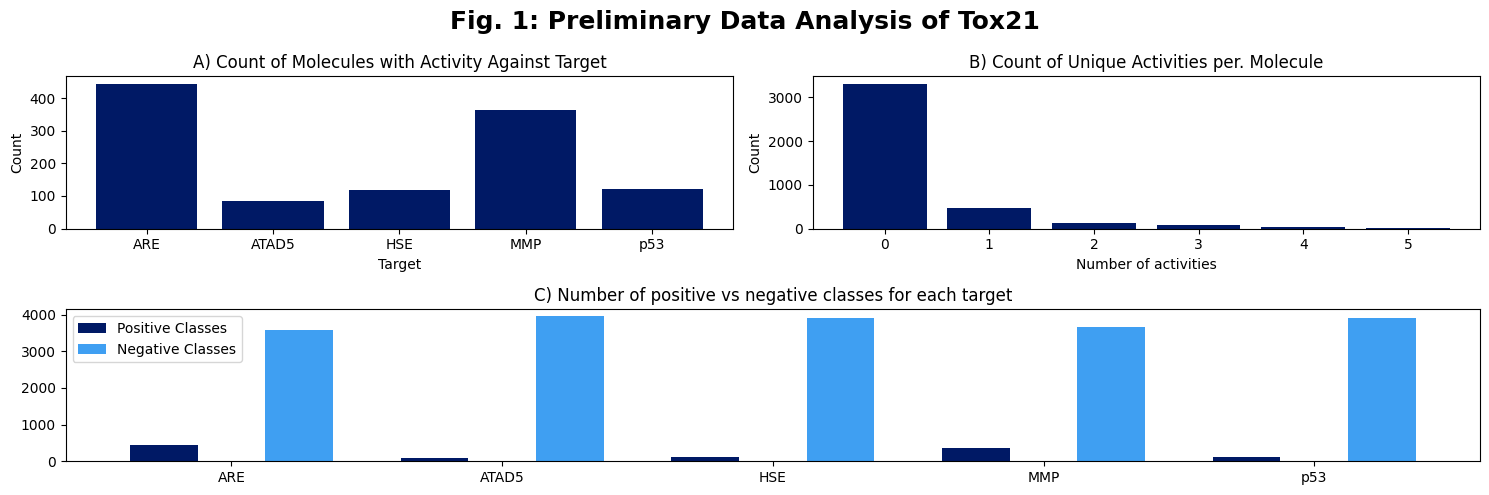

In [ ]:
makefig1()

#### **Downsampling the majority class (molecules with no activity)**
It became very apparent in the initial data analysis that molecules with no activity against any of the targets are vastly over represented in the dataset.

This is a problem, because the model is likely to focus heavily on the majority class (molecules with no activity) and ends up not learning anything from the minority. For that reason, i chose to downsample the minority class (inactive molecules). I do this by partitioning the dataset into molecules that have at least one biological activity (`data_active_mols_only`), and molecules that have no biological activities (`data_inactive_mols_only`). I then create a new dataframe that contains all the active molecules and an equal amount of inactive molecules. However, this only assures there are an equal amount of molecules with *any* activity an dmolecules with *no* activity.. If we look at the the level of a single target, for example ATAD5, there will still be way more molecules that have no activity towards ATAD5, than those that have, so the imbalance is still present at the level of the individual class.

In [ ]:
data_inactive_mols_only = data[(data["SR-ARE"] != 1.0) & (data["SR-ATAD5"] != 1.0) & (data["SR-HSE"] != 1.0) & (data["SR-MMP"] != 1.0) & (data["SR-p53"] != 1.0)]
data_active_mols_only = data[(data["SR-ARE"] == 1.0) | (data["SR-ATAD5"] == 1.0) | (data["SR-HSE"] == 1.0) | (data["SR-MMP"] == 1.0) | (data["SR-p53"] == 1.0)]

inactive_mols_sample = data_inactive_mols_only.sample(600, random_state = rand_state_of_choice)

data_undersampled = pd.concat([inactive_mols_sample, data_active_mols_only])

#data_undersampled_smiles = data_undersampled.smiles.values
#data_undersampled_tasks = data_undersampled[task_names]

task_freq_reciprocals = torch.tensor(np.reciprocal(data_undersampled[task_names].values.sum(axis = 0) / len(data_undersampled)), dtype = torch.long)

## **Some Theory**

#### **Binary cross entropy loss / log loss**
A binary multi-label classification requires from our output layer, that the values are scaled to the range $[0, 1]$, and that the value of the elements in the output vector are independent from one another. The first can be achieved by using the sigmoid function as the final operation in the model. The sigmoid function is defined as $\sigma(x)=\frac{1}{1+e^{-x}}$ and approaches 1 for larger positive numbers, and $0$ for larger negative numbers.

For the loss function i will use the cross entropy loss / log loss for which the loss indeed is independent for each element in the output vector.

The binary cross entropy loss is defined as:

$$\text{log loss}(y_i, p_i) =-(y_i \cdot log(p_i) + (1-y_i) \cdot log(1 - p_i))$$

Where $y_i$ is the class label, $p_i$ is the predicted probability of the positive class ($1$) and $1-p_i$ is then the predicted probability of the negative class ($0$).

If the class label $y_i$ is 0, then the first term in the sum is zeroed out. We then get:

$$
\text{log loss}(y_i, p_i) =-(0 \cdot log(p_i) + (1-0) \cdot log(1 - p_i))=-log(1 - p_i)
$$

So if the true class is 0, the model will be penalized as $p_i$ increases and the value inside the log term approaches 0.

If the class label $y_i$ is 1, then the second term in the sum is zeroed out.

$$
\text{log loss}(y_i, p_i) =-(1 \cdot log(p_i) + (1-1) \cdot log(1 - p_i))= -log(p_i)
$$

So if the true class is 1, the model will be penalized as as $p_i$ decreases and the value inside the log term again approaches 0.

Torch has a convenient loss function that combines taking the sigmoid of the output, with calculating the cross entropy loss, called `BCEWithLogitsLoss()`, which i will use for both models.

####**An example of MSE vs Log Loss**
Below I've made a plot that should show that the properties of the log-loss better fits a classification use case. In the plot are mock predicted values in range $[0, 1]$ like they would be from a classifier, and on the y-axis is the loss. The loss is plotted for a situation where the true label, $y=1$.

As the predicted value goes farther from the true value, the MSE linearly approaches 1, which is the maximum possible loss. The log-loss however, exponentially grows as the predicted value approaches 0. This means that the log-loss is much more sensitive to those predicted values that are very far for the true label, being able to give a much larger loss and thus allowing those predictions to contribute more to the gradient.

This fits a classification use-case very well, because a model that very certainly predicts that a molecule is not-toxic, e.g. predicting (0.001) should be penalized much more heavily than a prediction that lies somewhere in-between, e.g. (0.4).

<ipython-input-18-2dcda544ecf2>:4: RuntimeWarning: divide by zero encountered in log
  logloss_true_label_1 = -(np.log(spaced_nums))


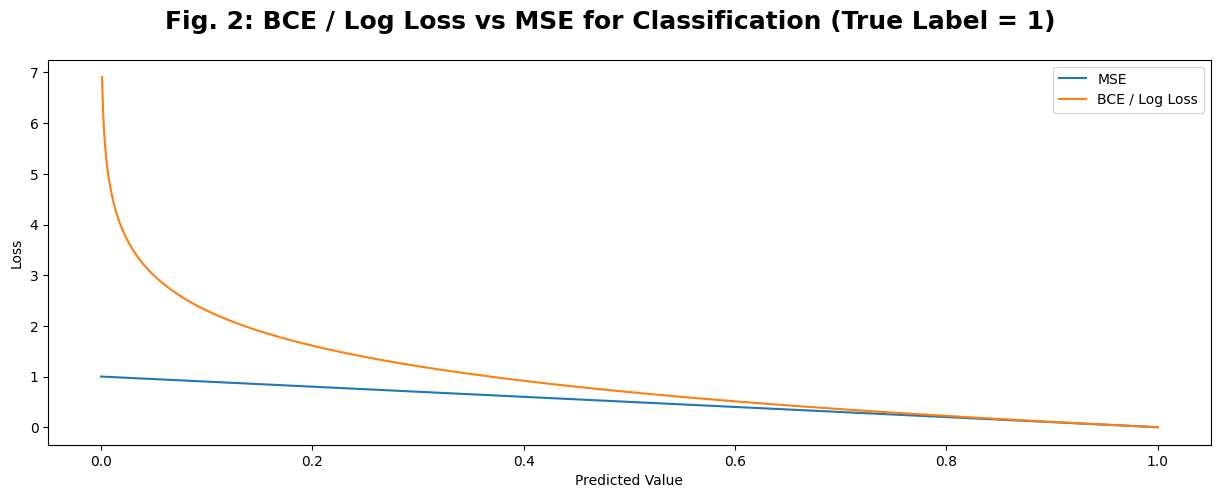

In [ ]:
makefig2()

#### **Dealing with the class imbalance - Upweighting positive examples**

The loss function from PyTorch further has one nice feature that helps to deal with the imbalanced data. This is that you can pass a vector of size `n_classes` to the loss function to give a larger weight to positive instances of the class. For example `class_weights = [10, 1, 1, 5, 1]` would increase the influence of positive examples from the first class by a factor 10 and those from the fourth class by a factor 5.

With the weights added, the loss function becomes

$$\text{weighted log loss} (y_i, p_i) =-(p_c \cdot y_i \cdot log(p_i) + (1-y_i) \cdot log(1 - p_i))$$

Where $p_c$ is the weight for a positive instance of class $c$. The weight is as seen only applied to when the instance is of the positive class, and thus helps boost the influence of positive instances of each class on the gradient.

#### **Preventing over- and underfitting**
For many datasets it can be easy to get a good performance on the training-set. But this also often means that the model doesn't generalize well to the unseen data in the testing or validation sets. This can be considered a symptom of the model not actual learning to pick up features that are useful for predicting the target variable, but rather learning the statistical noise inherent to the training set, allowing the model to 'remember' the input features (+ the noise) and their associated target variables.

When the model is performing very well on the training data but doesn't generalize to the test/validation data it is termed overfitting. To combat overfitting it is common to employ regularization techniques, such as dropout-layers and L2-regularization (also called weight-decay).

####**Dropout Layers**
A dropout layer is a layer that with some probability, $p$ zeroes or 'drops' a given input unit at each iteration/epoch. By dropping out neurons, the model is prevented from becoming dependent on the combined features that are output from single neurons, and learns to make predictions that are more generalized. The dropping out of a large number of neurons, effectively decreases the size of the model and lowers the complexity, preventing overfitting to the training data.

####**L2-regularization / Weight decay**
L2-regularization / weight decay involves adding a term to the loss function, that depends on the squared magnitude of the weights. This term is:

$$\lambda \sum_{i=1}^{n}\theta_{i}^2$$

with $\theta_i$ being weight $i$ and $\lambda$ being a constant we can use to scale the effect of the regularization up and down.

This effectively penalizes the model having any weights that are on a vastly different magnitude than the rest, and are a sign that the model is overfitting and depending heavily on single features.

#### **Learning-rate Decay**
Another problem that became apparent when trying to create a model on this very imbalanced data, is that the model has a strong tendency to fall into a local minima where it simply predicts 0 (the majority class) for all molecules. With a small learning rate (`1e-4` and below) this seemed very hard to avoid. With a larger learning rate, the model succeeds in escaping the local minima, but training becomes volatile/unstable, likely due to not being able to converge to a 'true' minima that might be very narrow, and incompatible with a larger learning rate.

Learning-rate decay seemed very effective in allowing my models to initially escape the local minima where a low loss is achieved by predicting the majority class, but then later on as the learning-rate decreases, converge to a sensible (hopefully) global minimum.

## **Train-Test Splitting**
The models i train will utilize the same train-test-split so i will do that from the start. I'll do an 80-10-10 train-test-validation split.

In [ ]:
train_data, test_data = train_test_split(data_undersampled, train_size = 0.8, random_state = rand_state_of_choice)    # Allocate 80 pct. of data for training
test_data, val_data = train_test_split(test_data, train_size = 0.5, random_state = rand_state_of_choice)              # Split the remaining 20 pct. into test and validation

train_smiles, y_train = train_data.smiles.values, torch.tensor(train_data[task_names].values, dtype = torch.float)    # Save the SMILES for each set in own variables, and the labels as tensors in their own variables.
test_smiles, y_test = test_data.smiles.values, torch.tensor(test_data[task_names].values, dtype = torch.float)
val_smiles, y_val = val_data.smiles.values, torch.tensor(val_data[task_names].values, dtype = torch.float)

## **Model Architecture I: The Deep Neural Network**

The first architecture i will be testing on the dataset is the deep neural net. For the deep neural net, each molecule is featurized into a single feature vector of arbitrary size and passed through a series of layers.

### **Featurizing using Extended-Connectivity Fingerprints**

For the DNN, each molecule must be represented by a vector of arbitrary size. I here create a class that for each molecule passed, makes a feature vector consisting of the ECFP/morgan fingerprint, as well as a variety of whole-molecule descriptors such as molecular weight, number of hydrogen bond acceptors/donors, number of rings etc.  This class is called `MoleculeToFeatureVector()` and utilizes the class `NumpyFingerprinter()` that handles the generation of fingerprints as a numpy-array.

#### **Classes for Molecule-Level Featurization using Fingerprints and Molecular Descriptors**

In [ ]:
class NumpyFingerprinter():
  """
  Handles the creation of ECFPs using RDKit. Converts one or a list of molecules into a single (n_mols x n_bits) NumPy-array of fingerprints.
  Used by MoleculeToFeatureVector.
  """
  def __init__(self, radius, n_bits, useCounts = False):
    self.radius = radius
    self.n_bits = n_bits
    self.useCounts = useCounts
    self.fpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=self.radius, fpSize=self.n_bits)

  def get(self, molecules):

    if type(molecules) != list:
      try:
        molecules = [molecules]
      except:
        raise TypeError("You passed a datatype to molecules that couldn't be converted to a list.")

    n_molecules = len(molecules)
    return_array = np.zeros((n_molecules, self.n_bits))

    for i, molecule in enumerate(molecules):
      if self.useCounts:
        fp = self.fpgen.GetCountFingerprintAsNumPy(molecule)
      else:
        fp = self.fpgen.GetCountFingerprintAsNumPy(molecule)

      return_array[i] = fp

    return return_array

In [ ]:
class MoleculeToFeatureVector():
  """
  Encodes molecules as feature vector as per keywords passed to feature_list
  """

  def __init__(self, feature_list, fp_size = None, fp_radius = None, fpUseCounts = None, returnTensor = True, max_atoms_in_dset = None):
    self.feature_list = feature_list
    self.feature_dim = None
    self.fp_size = fp_size
    self.fp_radius = fp_radius
    self.fpUseCounts = fpUseCounts
    self.returnTensor = returnTensor
    self.max_atoms_in_dset = max_atoms_in_dset

  def get_fingerprint(self):
    self.fp_gen = NumpyFingerprinter(radius = self.fp_radius, n_bits = self.fp_size, useCounts = self.fpUseCounts)
    fps = self.fp_gen.get(self.molecules)
    return fps

  def get_rd_descriptors(self):

    functions = (
        Descriptors.ExactMolWt,
        Descriptors.MolLogP,
        rdMolDescriptors.CalcTPSA,
        rdMolDescriptors.CalcNumHBA,
        rdMolDescriptors.CalcNumHBD,
        rdMolDescriptors.CalcNumRings,
        rdMolDescriptors.CalcNumRotatableBonds,
        rdMolDescriptors.CalcNumAmideBonds,
        rdMolDescriptors.CalcNumHeterocycles,
        rdMolDescriptors.CalcNumAtoms,
        rdMolDescriptors.CalcNumBridgeheadAtoms,
        rdMolDescriptors.CalcNumHeavyAtoms,
        rdMolDescriptors.CalcNumSpiroAtoms,
        rdMolDescriptors.CalcNumSaturatedRings,
        Chem.Lipinski.FractionCSP3,
    )

    n_descriptors = len(functions)

    _descriptors = np.zeros((self.n_mols, n_descriptors))

    for i, molecule in enumerate(self.molecules):

      vec = np.zeros(len(functions))

      for j, fun in enumerate(functions):
        vec[j] = fun(molecule)

      _descriptors[i] = vec

    _descriptors = np.nan_to_num(_descriptors, neginf = 0.0, posinf = 0.0, nan = 0.0)

    return _descriptors

  def get_partial_charges(self):

    partial_charge_array =  np.zeros((self.n_mols, self.max_atoms_in_dset))

    for i, molecule in enumerate(self.molecules):
      Chem.rdPartialCharges.ComputeGasteigerCharges(molecule)
      mol_partial_charge_vec = np.array([atom.GetDoubleProp('_GasteigerCharge') for atom in molecule.GetAtoms()], dtype = float)
      mol_partial_charge_vec = np.nan_to_num(mol_partial_charge_vec, nan = 0.0, posinf = 0.0, neginf = 0.0)
      width = mol_partial_charge_vec.shape[0]
      width_diff = self.max_atoms_in_dset - width
      mol_partial_charge_vec = np.pad(array = mol_partial_charge_vec, pad_width = (0, width_diff))
      partial_charge_array[i] = mol_partial_charge_vec

    return partial_charge_array

  def get(self, molecules, silence = False):

    self.molecules = molecules
    self.n_mols = len(self.molecules)

    self.funmap = {
        "ecfp": self.get_fingerprint,
        "rd_descriptors": self.get_rd_descriptors,
        "rdPartialCharges": self.get_partial_charges
        }

    X = np.hstack([self.funmap[feature]() for feature in self.feature_list])

    if self.returnTensor:
      return torch.tensor(X, dtype = torch.float)

    else:
      return X

### **Creating Classes For The Deep Neural Net**

In [ ]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, layers = None):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

In [ ]:
class NeuralNetTrainerV2():

  def __init__(self, model, criterion, optimizer, tqdm_disabled = False, scheduler_tuple = (StepLR, 5, 0.1)):
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.tqdm_disabled = tqdm_disabled

    if scheduler_tuple is not None:
      self.using_scheduler = True
      self._scheduler, self.step_size, self.gamma = scheduler_tuple
      self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)

  def train_one_epoch(self, d):
    self.model.train()
    x, y = d                          # Split training instance into X and y
    out = self.model(x)               # Forward propagate
    loss = self.criterion(out, y)     # Compute the loss
    self.optimizer.zero_grad()        # Clear any old gradients from any prev. training
    loss.backward()                   # Derives gradients.
    self.optimizer.step()             # Updates trainable parameters based on gradients.
    self.optimizer.zero_grad()        # Clear the gradients post-step, ready for next epoch.
    return loss

  @torch.no_grad
  def validate_one_epoch(self, val_d):
    self.model.eval()
    x, y = val_d
    out = self.model(x)
    loss = self.criterion(out, y)
    return loss

  def train(self, train_data, val_data, eta = 0.001, batch_size = 16, n_epochs = 50):

    self.batch_size = batch_size
    self.train_dataloader = DataLoader(train_data, batch_size = batch_size)
    self.val_dataloader = DataLoader(val_data, batch_size = len(val_data))

    self.loss_history = []
    self.val_loss_history = []

    for epoch in tqdm(range(n_epochs), disable = self.tqdm_disabled):

      # Accumulate a running loss over all training instances for both train and val. sets
      epoch_loss = 0
      epoch_val_loss = 0

      # No. of batches in each dataloader
      n_train_batches = len(self.train_dataloader)
      n_val_batches = len(self.val_dataloader)

      # Train on each batch in train-set
      for d in self.train_dataloader:
        loss = self.train_one_epoch(d)
        epoch_loss += loss.item()

      # Validate on each batch in val-set
      for val_d in self.val_dataloader:
        val_loss = self.validate_one_epoch(val_d)
        epoch_val_loss += val_loss.item()

      # Divide the running loss by the number of batches and append to the loss histories
      self.loss_history.append(epoch_loss)
      self.val_loss_history.append(epoch_val_loss)

      if self.using_scheduler:
        self.scheduler.step()


  @torch.no_grad
  def predict(self, dlist):
      self.model.eval()

      x = dlist.tensors[0]
      out = self.model(x)

      return out

  def load_state_dict(self, state_dict):
    self.model.load_state_dict(state_dict)


### **Training the model**
Now the data has been processed and the classes for the DNN are ready to go. I will now do a 80-10-10 train-test-validation split, featurize the molecules and train the DNN.

In [ ]:
unique_atoms_map, max_atoms_in_dset = map_atoms_in_dataset(smiles)
VectorFeaturizer = MoleculeToFeatureVector(["ecfp", "rd_descriptors"], fp_size = 2048, fp_radius = 2, fpUseCounts = False, returnTensor = True, max_atoms_in_dset = max_atoms_in_dset)

  0%|          | 0/4036 [00:00<?, ?it/s]

In [ ]:
# Convert SMILES in each set to mols, then apply the featurizer to each set.
#train_mols, test_mols, val_mols = ([Chem.MolFromSmiles(smile) for smile in smiles] for smiles in (train_smiles, test_smiles, val_smiles))

train_mols = [Chem.MolFromSmiles(i) for i in train_smiles]
test_mols = [Chem.MolFromSmiles(i) for i in test_smiles]
val_mols = [Chem.MolFromSmiles(i) for i in val_smiles]

dnn_X_train, dnn_X_test, dnn_X_val = (VectorFeaturizer.get(i) for i in (train_mols, test_mols, val_mols))

# Fit StandardScaler to train data, apply and transform the train, test and val sets.
sc = StandardScaler().fit(dnn_X_train)

# Transform each set, and convert back to float tensor.
to_double = lambda X: torch.tensor(X, dtype = torch.float)

dnn_X_train = to_double(sc.transform(dnn_X_train))
dnn_X_test = to_double(sc.transform(dnn_X_test))
dnn_X_val = to_double(sc.transform(dnn_X_val))

# Create PyTorch compatible datasets for each set.
dnn_train_data = TensorDataset(dnn_X_train, y_train)
dnn_test_data = TensorDataset(dnn_X_test, y_test)
dnn_val_data  = TensorDataset(dnn_X_val, y_val)

print(dnn_X_train.shape, dnn_X_test.shape, dnn_X_val.shape)

torch.Size([1057, 2063]) torch.Size([132, 2063]) torch.Size([133, 2063])


In [ ]:
dnn_input_dim = dnn_X_train.shape[1]
dnn_output_dim = n_tasks

In [ ]:
# Setting up the deep neural network with layers, activation functions and a few dropout layers.

dnn_model = NeuralNetwork(
    layers = (
        nn.BatchNorm1d(num_features = dnn_input_dim),
        nn.Linear(dnn_input_dim, 1528),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(1528, 612),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(612, 256),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(256, dnn_output_dim),
        )
)

In [ ]:
dnn_trainer = NeuralNetTrainerV2(
    model = dnn_model,
    criterion = nn.BCEWithLogitsLoss(pos_weight = task_freq_reciprocals * 0.9),                           # Set the loss function, with pos_weight being vector defining weights for positives instances of each class
    optimizer = torch.optim.AdamW(params=dnn_model.parameters(), lr = 2e-3, weight_decay = 1e-3),         # lr sets learning rate, weight_decay sets lambda for L2 regularization
    scheduler_tuple = (StepLR, 10, 0.4)                                                                   # Every ten epochs, multply current learning rate with 0.4 to get new learning rate.
    )

dnn_trainer.train(dnn_train_data, dnn_val_data, batch_size = 128, n_epochs = 35)

  0%|          | 0/35 [00:00<?, ?it/s]

### **Looking at the loss-history of the DNN**

It can easily be seen that the DNN-model is quite overfit. But at least the training is quite stable, and the loss is convering for the training data. We can see what impact this has on the predictions, when we get to the confusion matrices.

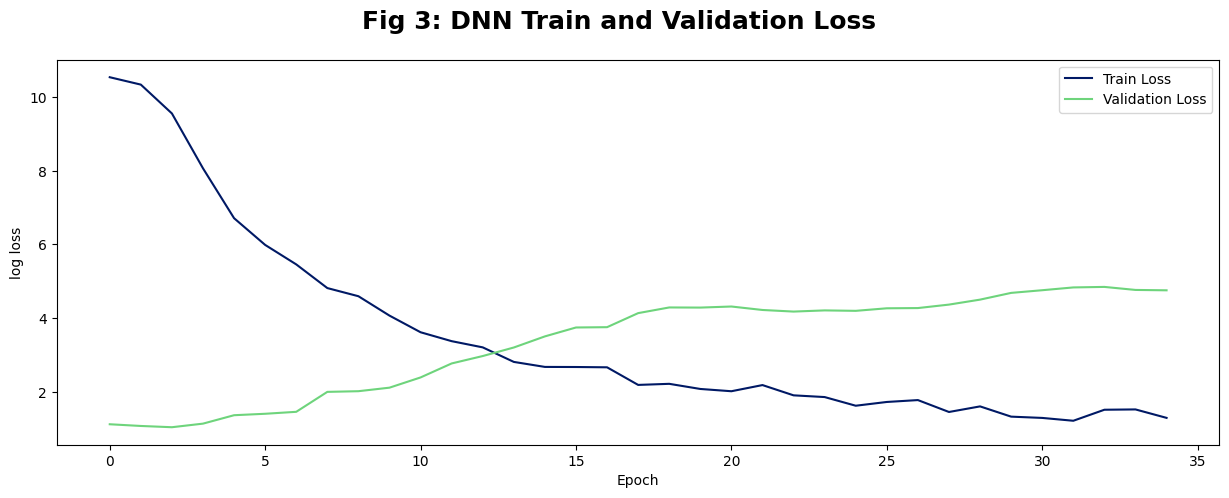

In [ ]:
dnn_train_loss_history = dnn_trainer.loss_history
dnn_val_loss_history = dnn_trainer.val_loss_history


plot_loss_curve(dnn_train_loss_history, dnn_val_loss_history, c1 = blue, c2 = green, ylab = "log loss", title = "Fig 3: DNN Train and Validation Loss")

### **Confusion Matrices for the DNN**
In a regression model it is easy to quantify the performance with a single number, with measures such as the mean squared error, mean absolute error or coefficient of determination. For a classification model, the loss itself is not that interesting, because the model can be right/wrong in different ways. One way to visualize this is a confusion matrix - a $2\cdot2$ matrix - that show the number of true positives, false positives, true negatives and false negatives. To be able to see if the performance differes for the different stress-response pathways, i will create one confusion-matrix per class.

In [ ]:
# Make the DNN's predictions on all sets
dnn_train_preds, dnn_test_preds, dnn_val_preds = map(dnn_trainer.predict, [dnn_train_data, dnn_test_data, dnn_val_data])

# Binarize the DNN's predictions
dnn_train_preds_bool, dnn_test_preds_bool, dnn_val_preds_bool = map(binarize_predictions, [dnn_train_preds, dnn_test_preds, dnn_val_preds])

In [ ]:
# Compute confusion matrices
dnn_cfm_train = multilabel_confusion_matrix(y_train, dnn_train_preds_bool)
dnn_cfm_test = multilabel_confusion_matrix(y_test, dnn_test_preds_bool)
dnn_cfm_val = multilabel_confusion_matrix(y_val, dnn_val_preds_bool)

# Compute Classification Metrics
dnn_train_metric_df = compute_classification_metrics(y_true=y_train, y_pred=dnn_train_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 1: DNN Metrics (Train)")
dnn_test_metric_df = compute_classification_metrics(y_true=y_test, y_pred=dnn_test_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 2: DNN Metrics (Test)")
dnn_val_metric_df = compute_classification_metrics(y_true=y_val, y_pred=dnn_val_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 3: DNN Metrics (Validation)")

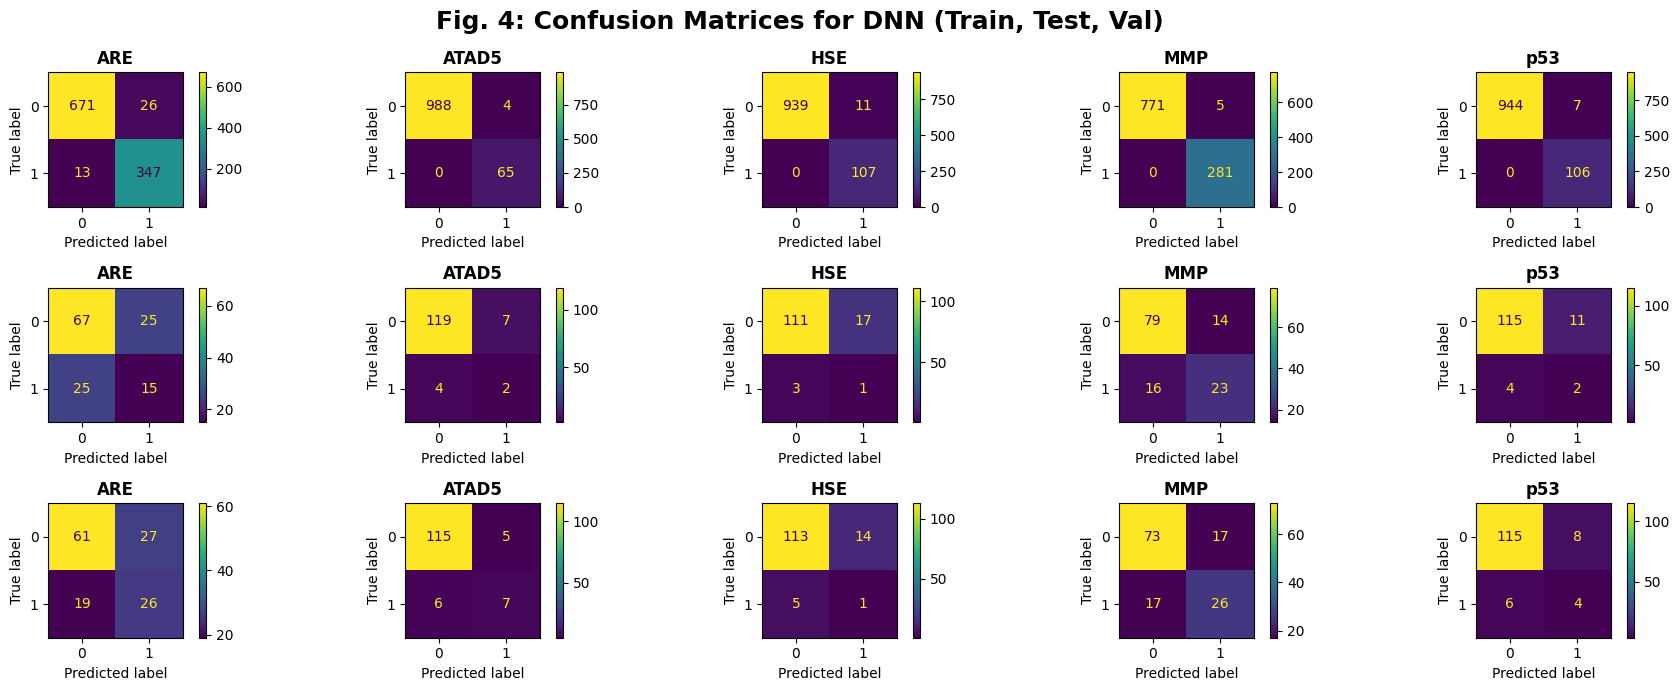

In [ ]:
plot_cfms(cfms = [dnn_cfm_train, dnn_cfm_test, dnn_cfm_val], class_names = target_names, suptitle = "Fig. 4: Confusion Matrices for DNN (Train, Test, Val)")

### **Common Metrics for Classifiers**

#### **Accuracy**
The accuracy is the ratio of correct predictions to all predictions.
$$\text{accuracy}=\frac{TN+TP}{TP+FP+TN+FN}$$

Accuracy is a bad measure for this model, due to the heavy imbalance. The weight of the true negatives in the numerator will give a false impression of a well-performing model. A null-model that simply predicts 0 for every class, will achieve a very good accuracy, despite not classifying intelligently. More generally, the probability of drawing a negative instance from the data is much higher than that of a positive, so even a model, for which the predictions are completely random, would likely get a very good accuracy as well.

#### **Precision**
The precision is the ratio of instances correctly classified as the positive class, to all instances classified as the positive class.

$$\text{precision}=\frac{TP}{TP+FP}$$

For this dataset, the precision is a good measure of performance, as it quantifies how well we can believe the model when it classifies a molecule as being toxic. If the precision is high, then most of the molecules that are classified as toxic, are in fact toxic. If the precision is low, a lot of non-toxic molecules are being classified as toxic. If we consider a real-life case, for example in a pharma company were the model is used to screen drug-candidates then a model with a low precision would disqualify a lot of interesting molecules from further research, despite them not actually being toxic.

#### **Sensitivity / Recall**
Sensitivity or Recall is the ratio of correctly classified elements of the positive class, to all elements belonging to the positive class.
$$\text{recall}=\frac{TP}{TP+FN}$$

The sensitivity or recall is also a good measure for this dataset. It quantifies how many of the molecules of the toxic molecules that were spotted, out of all the toxic molecules. If we have a low sensitivity, it means that many molecules are classified as non-toxic even though they are in fact toxic. In a real-life setting that's sort of a worst-case scenario, that the toxic molecules are not being recognized, and could end up being used in some sort of application.

#### **Specificity**
The specificity is the ratio of correctly classified elements of the negative class, to all elements belonging to the negative class.
$$\text{specificity}=\frac{TN}{TN+FP}$$

The specificity quantifies, how many of the non-toxic molecules that were actually classified as such. The specificity is also not a very good measure for this dataset, again because the data is skewed such that most instances are of the negative class, and therefore the probability of a true-negative is high even for a non-skilled model.

#### **F1-score**
The F1-score combines the precision and recall into a single metric by taking the harmonic mean of the two.

$$\text{f1 score}=\frac{2}{\text{Precision}^{-1}+\text{Recall}^{-1}}$$

If the F1-score is close to one, the precision and recall are generally higher and balanced, meaning that the model is on one hand unlikely to produce false positives (classify a non-toxic molecule as toxic) but on the other hand is also unlikely to produce false negatives, by missing a toxic molecule and classifying it as non-toxic.

I would argue that for a dataset imbalanced towards the negative class, the F1-score is the best metric of the ones discussed, due to not being influenced by a high number of true negatives, and because it combines the precision and recall into a single measure.

### **Classification Metrics for the DNN**

In [ ]:
display_side_by_side([dnn_train_metric_df, dnn_test_metric_df, dnn_val_metric_df], tablespacing = 25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.96,1.00,0.99,1.00,0.99
Precision,0.93,0.94,0.91,0.98,0.94
Recall,0.96,1.00,1.00,1.00,1.00
F1,0.95,0.97,0.95,0.99,0.97
Specificity,0.96,1.00,0.99,0.99,0.99
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.62,0.92,0.85,0.77,0.89
Precision,0.38,0.22,0.06,0.62,0.15
Recall,0.38,0.33,0.25,0.59,0.33
F1,0.38,0.27,0.09,0.61,0.21


### **Cross Validation of the DNN**
It is interesting to see how much the random train-test-validation split influences the performance of the DNN-based classifier. If the model can consistently pick up general chemical features that are important for predicting activation of the stress responses, then the metrics should not vary much regardless of the train test split. If on the other hand, the molecules with features that are specifically important for predicting toxicity all end up in the test-validation set, so the model has not had a chance to see and learn these features, then we would expect a much higher variability in the performance.

### **Coded used for cross-validation**

```python
train_f1_scores = []
test_f1_scores = []
val_f1_scores = []

for cross_val in tqdm(range(20)):
  train_data, test_data = train_test_split(data_undersampled, train_size = 0.8)    # Allocate 80 pct. of data for training
  test_data, val_data = train_test_split(test_data, train_size = 0.5)              # Split the remaining 20 pct. into test and validation

  train_smiles, y_train = train_data.smiles.values, torch.tensor(train_data[task_names].values, dtype = torch.float)    # Save the SMILES for each set in own variables, and the labels as tensors in their own variables.
  test_smiles, y_test = test_data.smiles.values, torch.tensor(test_data[task_names].values, dtype = torch.float)
  val_smiles, y_val = val_data.smiles.values, torch.tensor(val_data[task_names].values, dtype = torch.float)

  # Convert SMILES in each set to mols, then apply the featurizer to each set.
  #train_mols, test_mols, val_mols = ([Chem.MolFromSmiles(smile) for smile in smiles] for smiles in (train_smiles, test_smiles, val_smiles))

  train_mols = [Chem.MolFromSmiles(i) for i in train_smiles]
  test_mols = [Chem.MolFromSmiles(i) for i in test_smiles]
  val_mols = [Chem.MolFromSmiles(i) for i in val_smiles]

  dnn_X_train, dnn_X_test, dnn_X_val = (VectorFeaturizer.get(i) for i in (train_mols, test_mols, val_mols))

  # Fit StandardScaler to train data, apply and transform the train, test and val sets.
  sc = StandardScaler().fit(dnn_X_train)

  # Transform each set, and convert back to float tensor.
  to_double = lambda X: torch.tensor(X, dtype = torch.float)

  dnn_X_train = to_double(sc.transform(dnn_X_train))
  dnn_X_test = to_double(sc.transform(dnn_X_test))
  dnn_X_val = to_double(sc.transform(dnn_X_val))

  # Create PyTorch compatible datasets for each set.
  dnn_train_data = TensorDataset(dnn_X_train, y_train)
  dnn_test_data = TensorDataset(dnn_X_test, y_test)
  dnn_val_data  = TensorDataset(dnn_X_val, y_val)

  dnn_trainer = NeuralNetTrainerV2(
    model = dnn_model,
    criterion = nn.BCEWithLogitsLoss(pos_weight = task_freq_reciprocals * 0.9),                           # Set the loss function, with pos_weight being vector defining weights for positives instances of each class
    optimizer = torch.optim.AdamW(params=dnn_model.parameters(), lr = 2e-3, weight_decay = 1e-3),         # lr sets learning rate, weight_decay sets lambda for L2 regularization
    scheduler_tuple = (StepLR, 10, 0.4)                                                                   # Every ten epochs, multply current learning rate with 0.4 to get new learning rate.
    )

  dnn_trainer.train(dnn_train_data, dnn_val_data, batch_size = 128, n_epochs = 35)

  # Make the DNN's predictions on all sets
  dnn_train_preds, dnn_test_preds, dnn_val_preds = map(dnn_trainer.predict, [dnn_train_data, dnn_test_data, dnn_val_data])

  # Binarize the DNN's predictions
  dnn_train_preds_bool, dnn_test_preds_bool, dnn_val_preds_bool = map(binarize_predictions, [dnn_train_preds, dnn_test_preds, dnn_val_preds])

  train_f1 = f1_score(y_train, dnn_train_preds_bool, average = None)
  test_f1 = f1_score(y_test, dnn_test_preds_bool, average = None)
  val_f1 = f1_score(y_val, dnn_val_preds_bool, average = None)

  train_f1_scores.append(train_f1)
  test_f1_scores.append(test_f1)
  val_f1_scores.append(val_f1)
  ```

### **Plotting Cross Validation for the DNN**
Below i load in the f1-scores for the 20 random train-test-splits and plot them for each class. We can see that the train f1 varies the least, which makes good sense because it's the largest set, and also it's the one we train one, so we are likely to get a good score regardless of how the split turns out. The test and validation sets vary more, especially for ATAD5, HSE and p53. So in conclusion the models performance does indeed vary a lot regardless of the split but it depends on which of the classes we are considering.

It is also obvious that the f1-score is consistenly highest for ARE and MMP. If we go back to fig. 1 that showed the initial data analysis, i showeed that these two classes have vastly more positive training instances than the others. Therefore it also makes good sense, that the model is consistently better to predict these classes, as it is statistically more likely to have seen sufficient examples during training.

In [ ]:
%%capture
!wget https://github.com/jrytved/mlmol_files/raw/main/final_proj_dnn_f1_scores/dnn_train_f1.txt -O ./dnn_train_f1.txt
!wget https://github.com/jrytved/mlmol_files/raw/main/final_proj_dnn_f1_scores/dnn_test_f1.txt -O ./dnn_test_f1.txt
!wget https://github.com/jrytved/mlmol_files/raw/main/final_proj_dnn_f1_scores/dnn_val_f1.txt -O ./dnn_val_f1.txt

In [ ]:
dnn_train_f1 = np.loadtxt("dnn_train_f1.txt")
dnn_test_f1 =np.loadtxt("dnn_test_f1.txt")
dnn_val_f1 =np.loadtxt("dnn_val_f1.txt")

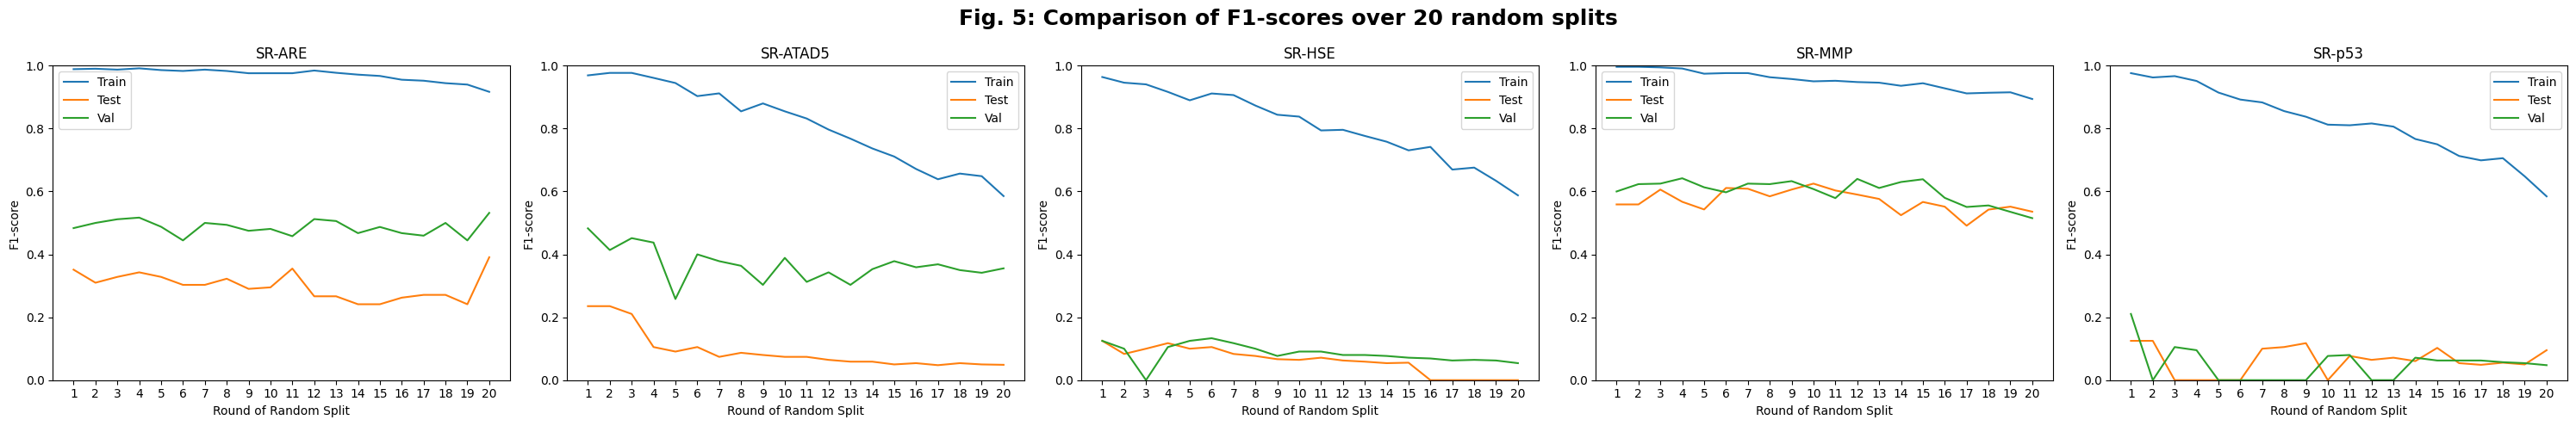

In [ ]:
makef1compfig()

## **Model Architecture II: The Graph Convolutional Neural Network**

### **More theory**
The following theory is adjusted a bit from the similar theory-paragraph i made in Assignment 3.

#### **Molecules as Graphs**

First, a graph $G=(V,E)$ consists of a set of vertices/nodes $V$ and a set of edges $E$ that connects them. One node can have many edges or a few edges. The number of edges associated with one node is called the degree. An edge can also be either be directed or undirected. Finally, an edge can also be self-directed, so it arises from the same node that it ends at.

The graph as whole can be cyclic or acyclic. For molecules our graphs will have to be cyclic. At least if we dont want to exclude every single molecule that has rings.

**The Adjacency Matrix**

To represent the connectivity of a graph, we can create the adjacency matrix $A$. $A$ is an $n \cdot n$-matrix with $n$ being the number of nodes in the graph. In the adjacency matrix, the element $A_{i,j}$ is 1 if node with index $i$ is connected to node with index $j$. Otherwise it is $0$.

**The Node Feature Matrix**

Each node may have a feature vector of size $m$. This gives our node feature matrix the shape $n \cdot m$ with $n$ again being the number of nodes and $m$ being the number of features. Since each node represents an atom there are many possibilities for features. It could for example be the atom type, aromaticity, hybridization, valence, formal-charge etc.

#### **The Graph Convolutional Neural Network**

In a graph convolutional neural network, the feature vector for each node are at each convolution updated by performing an aggregation of the feature vectors belonging to the neighbors of said node. The aggregation could for example be taking the mean of the features.

If we consider a molecule where node $1$ is neighbored by node $2$, $0$ and $3$, then after one convolution, the feature vector $x_1$ for node $1$ will be the mean of the feature vectors $x_2, x_0$ and $x_{3}$ as well as the feature vector of the node ($x_0$) itself. This also explains why we needed to add the the identity matrix, $I$ to our adjacency matrix, $A$. The identity matrix is simply a matrix with ones along the diagonals and zeros everywhere else. In other words $I_{i,j}$ is 1 if $i=j$ and otherwise it is zero. This corresponds to adding a self-directed edge for all nodes. If we didnt, then the node that the convolution operation is applied to does not have an edge directed to itself, and it would not have it's own feature vector take part in the aggregation when doing the convolution.


It also here becomes apparent what the similarity between a regular CNN that operates on regular matrices, and the GCN that operates on graph. In the CNN a sliding window or 'filter' passes over the matrix one element at a time, aggregating features to create a new representation. Likewise the GCN operates on one node at a time (one atom in this case) and updates that atoms feature vector, by aggregating the feature vectors of it's own neighbors, leading to a new representation.

By adjusting the amount of convolutions we make, we determine how 'far' each message is passed throughout the graph. If we make 1 convolution, the message from node $n_1$ is only passed to it's neighbours. If we do 2 convolutions then the previously made aggregations are now passed forward, so some information from each node is now passed to nodes that are two 'hops' away.

To introduce trainable parameters, each convolutional layer gets a weight matrix that is multiplied on the aggregated node features. This will allow the model to learn to extract the most important features after each convolution.

#### **The Math**
The equation for a graph convolutional layer is a function of the feature matrix $X$ and adjacency matrix $A$.

$$H_1=f(X,A)=\sigma(D^{-1/2}(A+I)D^{-1/2}XW_1)$$

Here we introduce $I$ that is the identity matrix and has the shape $n \cdot n$ with $n$ being the number of nodes. The identity matrix has ones along the diagonal and 0's everywhere else. The reason for adding the identity matrix to the adjacency is to add self-loops. by adding a 1 at all elements in $A_{i,j}$ where $i=j$ we create a self directed edge for all nodes.

We also introduce the normalized degree matrix $D^{1/2}$. The degree matrix is a a diagonal matrix like $I$ where each element $i,i$ has the number of neighbors for node $i$. This can be calculated by summing along one of the axises in $(A+I)$ and then casting the resulting vector along the diagonal of matrix with shape $n \cdot n$.

The degree matrix, $D$, is normalized by taking the reciprocal of the square root of each element in $D$. This serves to normalize the impact of the feature vectors on the message passing, to the degree of each node. We can imagine that a node with many neighbors (high degree) will have a high influence of the aggregated features of other nodes in the network, while a node with few neighbors (low degree) will have very little influence, if this normalization was not performed. The normalization combats this by essentially making the signal coming from nodes with many neighbors smaller.

Finally, $\sigma$ denotes a non-linear activation functions that we apply to the embedding output from the convolutional layer.

We called the output of the first convolutional layer $H_1$ to do several convolutions we simply stack the layers in the manner:

$$H_1 = f(X,A)$$
$$H_2 = f(H_1,A)$$
$$H_3 = f(H_2,A)$$

Each layer $L$ has it's own trainable weight matrix $W_L$.

### **Featurizing at the atomic level**

Here i create the class `MoleculeToFeatureMatrix()`, that i use to featurize molecules at the atomic level. This means that any molecule is featurized into a matrix of shape `(n_atoms, n_features)`. Among the simpler features are hybridization-state, partial-charges, aromaticity, n-hydrogens and formal_charge. I also included the coulomb matrix that quantifies electrostatic interactions between each pair of nuclei. This is based on coulombs law, and calculated using interatomic distances for each pair of atoms, meaning that it also contributes some degree of spatial information, which could indeed be good when considering that a probable cause of activation of some cellular stress response pathways, could be the small molecules interacting with and activating/inhibiting certain proteins. Lastly, rdkit generated estimated partial charges are also included.


In [ ]:
class MoleculeToFeatureMatrix():

  """
  A class to encode molecules as an n_nodes/n_atoms x n_features matrix.

  Args:
    features: list of keywords corresponding to the wanted features.
    max_atoms_in_data: integer of the maximal amount of atoms a molecule in the dataset can hae.
    unique_atoms_map: dictionary mapping all atomic numbers found in the dataset to an integer
  """

  def __init__(self, features: list, unique_atoms_map, max_atoms_in_data):
    self.features = features
    self.max_atoms_in_data = max_atoms_in_data
    self.unique_atoms_map = unique_atoms_map
    self.max_unique_atoms = len(self.unique_atoms_map)

  def encode_atoms(self):

    # An empty n_atoms x max_unique_atoms vector
    mat = np.zeros((self.n_atoms, self.max_unique_atoms))

    for i, atom in enumerate(self.atoms):
      atomic_number = atom.GetAtomicNum()                 # Fetch the atomic no. of the atom
      mat_index = self.unique_atoms_map[atomic_number]    # Find the integer that the atomic no. is mapped to
      mat[i][mat_index] = 1                               # One hot encode it at the index corresponding to that integer.

    return mat

  def encode_hybridization(self):
    """One hot encodes hybridization"""

    # Dictionary of hybridization types available in rdkit

    hybridization_types =  {
      rdkit.Chem.rdchem.HybridizationType.UNSPECIFIED: 0,
      rdkit.Chem.rdchem.HybridizationType.S: 1,
      rdkit.Chem.rdchem.HybridizationType.SP: 2,
      rdkit.Chem.rdchem.HybridizationType.SP2: 3,
      rdkit.Chem.rdchem.HybridizationType.SP3: 4,
      rdkit.Chem.rdchem.HybridizationType.SP2D: 5,
      rdkit.Chem.rdchem.HybridizationType.SP3D: 6,
      rdkit.Chem.rdchem.HybridizationType.SP3D2: 7,
      rdkit.Chem.rdchem.HybridizationType.OTHER: 8
    }

    # An empty n_atoms x number of available hybridization types vector
    mat = np.zeros((self.n_atoms, len(hybridization_types)))

    for i, atom in enumerate(self.atoms):
      idx = hybridization_types[atom.GetHybridization()]     # Get the hybridization type and the integer that iti s mapped to
      mat[i][idx] = 1                                             # One-hot-encode it at the index corresponding to that integer.
    return mat

  def encode_partial_charge(self):
    ComputeGasteigerCharges(self.mol)                             # Use the Marsili-Gasteiger algorithm to approximate partial charges of all atoms
    mat = np.zeros((self.n_atoms, 1))                             # A n_atoms sized vector to hold the partial charges

    for i, atom in enumerate(self.atoms):
      pc = atom.GetDoubleProp('_GasteigerCharge')                 # For each i, atom, get the partial charge

      if math.isnan(pc) or math.isinf(pc):                        # Replace partial charges calculated to NaN or inf. with 0's
        mat[i][0] = 0
      else:
        mat[i][0] = pc                                            # Assign the i'th element of the vector the value of the partial charge.

    return mat

  def encode_aromaticity(self):

    mat = np.zeros((self.n_atoms, 2))                             # Empty n_atoms x 2 vector. 1 => atom part of aromatic system, 0 otherwise

    for i, atom in enumerate(self.atoms):
      index = 1 if atom.GetIsAromatic() else 0                    # One-hot-encode the aromaticity.
      mat[i][index] = 1

    return mat

  def encode_implicit_Hs(self):
    """One-hot-encode number of implicit Hs (hardcoded up to 4 Hs)"""
    mat = np.zeros((self.n_atoms, 4))

    for i, atom in enumerate(self.atoms):
      index = atom.GetNumImplicitHs()
      mat[i][index] = 1                                           # One-hot-encode with the index determined by the number of implicit Hs

    return mat

  def encode_formal_charge(self):
    """One-hot-encodes formal charge"""
    map = {
        -3:   0,
        -2:   1,
        -1:   2,
        0:    3,
        1:    4,
        2:    5,
        3:    6
    }

    mat = np.zeros((self.n_atoms, len(map)))                        # Empty n_atoms x n_possible charges vector

    for i, atom in enumerate(self.atoms):                           # For each atom, find the formal charge and get the mapped integer
      index = map[atom.GetFormalCharge()]
      mat[i][index] = 1                                             # One-hot-encode at the index corresponding to that integer

    return mat

  def encode_coulomb_matrix(self):
    """
    Computes a coulomb matrix for the molecule.
    Due to varying molecule size, the matrix is padded up to max_atoms_in_data along the 1st dimension.
    """

    return GetTensorCoulombMatrix(self.mol, pad_up_to = self.max_atoms_in_data, skipConformerGeneration = True)

  def encode_ring_sizes(self):
    map = [4, 5, 6]
    mat = np.zeros((self.n_atoms, len(map)))

    for i, atom in enumerate(self.atoms):
      for j, ring_size in enumerate(map):
        if atom.IsInRingSize(ring_size):
          mat[i][j] = 1

    return mat

  def generate_conformer_for_mol(self):
    self.mol = Chem.AddHs(self.mol)

    ps = AllChem.ETKDGv2()
    AllChem.EmbedMolecule(self.mol, ps)

    if self.mol.GetNumConformers() == 0: # If conformer generation fails the first time around, try to start from random coordinates
      ps.useRandomCoords = True
      AllChem.EmbedMolecule(self.mol, ps)

  def get(self, smiles: np.ndarray, y = None):

    self.mol = Chem.MolFromSmiles(smiles)
    self.generate_conformer_for_mol()

    self.atoms = self.mol.GetAtoms()
    self.bonds = self.mol.GetBonds()
    self.n_atoms = self.mol.GetNumAtoms()

    self.funmap = {                                                         # Maps each keyword to a function that returns the corresponding feature
        "atom_type": self.encode_atoms,
        "hybridization": self.encode_hybridization,
        "partial_charges": self.encode_partial_charge,
        "aromaticity": self.encode_aromaticity,
        "n_hydrogens": self.encode_implicit_Hs,
        "formal_charge": self.encode_formal_charge,
        "coulomb_matrix": self.encode_coulomb_matrix,
        "ring_sizes": self.encode_ring_sizes
        }

    node_feature_mat =  torch.tensor(np.hstack([self.funmap[feature]() for feature in self.features]), dtype = torch.float)

    return node_feature_mat

### **A GCN-class and a Model Trainer Class**

The class i made for the GCN is called `GCN()` and handles the forward propagation of
the atomic-level features. The class takes a list of convolutional layers, a pooling/aggregation function and a list of dense layers that proceeds the convolutions/pooling. Lastly, it also takes an activation function to be applied between each convolution.

In [ ]:
class GCN(torch.nn.Module):
    """

    Graph Convolutional Network class.

    conv_layers: List of convolutional layer
    pool_func: any pooling/aggregation function
    conv_act_fun: activation function for the convolutional layers
    dense_layers: List of dense layers proceeding the convolutional layers

    """

    def __init__(self, conv_layers, dense_layers, pool_func, conv_act_fun = nn.ReLU()):
        super(GCN, self).__init__()
        self.conv_layers = nn.ModuleList(conv_layers)
        self.dense_layers = nn.ModuleList(dense_layers)
        self.pool_func = pool_func
        self.conv_act_fun = conv_act_fun

    def forward(self, data):
        """Data is a torch.Data object with at least properties x and edge_index."""
        e = data.edge_index
        x = data.x

        for layer in self.conv_layers:
          x = layer(x, e)
          x = self.conv_act_fun(x)

        x = self.pool_func(x, batch = data.batch)

        for layer in self.dense_layers:
          x = layer(x)

        return x

Secondly i have created a trainer for the GCN, called `GNNTrainer()`. This takes a model (in this case an instance of `GCN()`), any torch criterion/loss-function, any torch-optimizer and lastly the keyword `tqdm_disabled` is just a way to turn off tqdm-based progress bars that I've built in to be able to see how far training has proceeded.

The `GNNTrainer()` handles the training by calling on the forward propagation of the model, then backpropagating and calculating gradients, before stepping (adjusting the weights) and then clearing the gradients to get ready for the next epoch/iteration.

The class also has a built in option to take a validation set, when you call the `train()` method, the trainer will evaluate the loss not only on the training but also on the validation set, so we can later check ou the training loss history and validation loss history respectively by the attributes `loss_history` and `val_loss_history`.

Lastly, the class also handles making predictions on unforeseen data through the `predict method`.

In [ ]:
class GNNTrainerV2():

  def __init__(self, model, criterion, optimizer, tqdm_disabled = False, scheduler_tuple = (StepLR, 5, 0.1)):
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.tqdm_disabled = tqdm_disabled
    self.using_scheduler = False

    if scheduler_tuple is not None:
      self.using_scheduler = True
      self._scheduler = scheduler_tuple[0]
      self.step_size = scheduler_tuple[1]
      self.gamma = scheduler_tuple[2]
      self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)

  def train_one_epoch(self, d):
    self.model.train()
    out = self.model(d)
    loss = self.criterion(out, d.y)   # Computes the loss
    loss.backward()                   # Derives gradients.
    self.optimizer.step()             # Updates trainable parameters based on gradients.
    self.optimizer.zero_grad()        # Clears the gradients.
    return loss

  @torch.no_grad
  def validate_one_epoch(self, val_d):
    self.model.eval()
    out = self.model(val_d)
    loss = self.criterion(out, val_d.y)
    return loss


  def train(self, datalist, valdatalist, batch_size = 16, n_epochs = 50):

    self.batch_size = batch_size
    self.dataloader = GraphDataLoader(datalist, batch_size=self.batch_size)
    self.val_dataloader = GraphDataLoader(valdatalist, batch_size = self.batch_size)
    self.loss_history = []
    self.val_loss_history = []

    for epoch in tqdm(range(n_epochs), disable = self.tqdm_disabled):
      epoch_loss = 0
      epoch_val_loss = 0

      for d in self.dataloader:
        loss = self.train_one_epoch(d)
        epoch_loss += loss.item()

      for val_d in self.val_dataloader:
        val_loss = self.validate_one_epoch(val_d)
        epoch_val_loss += val_loss.item()

      self.loss_history.append((epoch_loss / len(self.dataloader)))
      self.val_loss_history.append((epoch_val_loss / len(self.val_dataloader)))

      if self.using_scheduler:
        self.scheduler.step()

  @torch.no_grad
  def predict(self, dlist):
      self.model.eval()
      return torch.vstack([self.model(i) for i in tqdm(dlist, disable = self.tqdm_disabled)])

  def load_state_dict(self, state_dict):
    self.model.load_state_dict(state_dict)

### **Featurizing**

First i run my function `map_atoms_in_dataset()` to determine:
1. The largest molecules in the dataset (max no. atoms)
2. A mapping of all atoms to a unique integer

The reason for (1) is to determine how much we need to pad features that depend on the number of atoms in the molecule. For example, the coulomb matrix is of size `n_atoms x n_atoms` meaning that this feature for a large molecule will need a larger vector per atom. And the neural net can not implicitly deal with features of varying length, so all the individual feature matrices need to be padded in the 1'st dimension up to the largest number of atoms found in the dataset, to ensure equal shapes.

To understand the reason for (2) we can imagine one-hot-encoding each atom in a feature vector, with the atomic number deciding the index of the on-bit. Maybe the atom with the largest atomic number is Pb (82) but it is unlikely that every atom with atomic number 1-82 is represented in the dataset, and then the feature vector would be of size 82, even though perhaps only 30 of the elements were actually utilized. Therefore, `map_atoms_in_dataset()` loops over all unique atoms in the data, and maps every one of them to a unique integer corresponding to an index in the feature vector. In that way we save memory and avoid sparsity, by ensuring that there are no features that are consistently $0$ across the whole dataset.

I then perform the atomic-level featurization of each molecule. Included featires are: ` ["atom_type", "hybridization", "aromaticity", "n_hydrogens", "formal_charge", "coulomb_matrix", "ring_sizes", "partial_charges"]`.


All features except the coulomb matrix and partial charges are discrete and are therefore one-hot-encoded. But since they are on a vastly different magnitude than the one-hot-encoded features, they need to be normalized/scaled accordingly. This can be done by scaling them such that they lie in the range 0 to 1 when looking across the dataset as a whole.

In [ ]:
unique_atoms_map, max_atoms_in_dset = map_atoms_in_dataset(smiles)

  0%|          | 0/4036 [00:00<?, ?it/s]

In [ ]:
featurizer = MoleculeToFeatureMatrix(features = ["atom_type", "hybridization", "aromaticity", "n_hydrogens", "formal_charge", "coulomb_matrix", "ring_sizes", "partial_charges"], unique_atoms_map = unique_atoms_map, max_atoms_in_data = max_atoms_in_dset)

Feature scaling / normalization is done by fitting to the training dataset and then applying the transform to both the testing and validation set. This is done to ensure no leakage of information from the training data, as could happen if the transform was fit over all the available data.

In [ ]:
%%capture
gcn_X_train = [featurizer.get(i) for i in train_smiles]
gcn_X_test = [featurizer.get(i) for i in test_smiles]
gcn_X_val = [featurizer.get(i) for i in val_smiles]

sc = MinMaxScaler().fit(np.vstack(gcn_X_train))

gcn_X_train = map(sc.transform, gcn_X_train)
gcn_X_test =  map(sc.transform, gcn_X_test)
gcn_X_val =  map(sc.transform, gcn_X_val)

train_edge_idx = [EdgeIndexFromSmiles(i) for i in train_smiles]
test_edge_idx = [EdgeIndexFromSmiles(i) for i in test_smiles]
val_edge_idx = [EdgeIndexFromSmiles(i) for i in val_smiles]

train_dlist = [CreatePYGData(node_feature, edge_index, y) for node_feature, edge_index, y in zip(gcn_X_train, train_edge_idx, y_train)]
test_dlist = [CreatePYGData(node_feature, edge_index, y) for node_feature, edge_index, y in zip(gcn_X_test, test_edge_idx, y_test)]
val_dlist = [CreatePYGData(node_feature, edge_index, y) for node_feature, edge_index, y in zip(gcn_X_val, val_edge_idx, y_val)]

### **Training the GCN Model**

The GCN is trained with four convolutional layers with the output dimension of each being `convolution_dimension = 64`. The convolutions are followed by a pooling layer in which the node feature matrices are aggregated by the mean along the feature dimension into a single molecular embedding. Afterwards the embedding is passed through two dense layers of size 96 and 64 and finally the output layer of size 5, corresponding to the number of stress response pathways we are predicting on. The model uses both L2-regularization, a few dropout layers and a slight learning-rate decay.

In [ ]:
input_dim = train_dlist[0].x.shape[1]       # The input dimension / number of features
gcn_output_dim = n_tasks                    # The output dimension / no of classes

convolution_dimension = 64                  # The output dimension of each convolutional layer

# Instantiating the GCN-class with the convolutional layers, pooling layer and a few dense layers afterwards.

gcnmodel = GCN(

    conv_layers = [
        GCNConv(input_dim, convolution_dimension),
        GCNConv(convolution_dimension, convolution_dimension),
        GCNConv(convolution_dimension, convolution_dimension),
        GCNConv(convolution_dimension, convolution_dimension)
    ],

    dense_layers = [
        nn.Linear(convolution_dimension, 96),
        nn.ReLU(),
        nn.Dropout(0.0),
        nn.Linear(96, 64),
        nn.ReLU(),
        nn.Linear(64, gcn_output_dim)
    ],

    pool_func = gnn.global_mean_pool, # Pooling function to be applied after convolutions
    conv_act_fun = nn.ReLU()          # Activation function to be applied after each convolution
)

# Instantiating the model-trainer, setup of learning rate, L2-regularization, learning-rate decay, etc...

GCNTrainer = GNNTrainerV2(
                model = gcnmodel,
                criterion = nn.BCEWithLogitsLoss(pos_weight = task_freq_reciprocals * 0.7),
                optimizer = torch.optim.AdamW(params=gcnmodel.parameters(), lr= 2e-3, weight_decay = 1e-2),
                scheduler_tuple = (StepLR, 10, 0.9)
                )

# Actually training the model!

GCNTrainer.train(train_dlist, val_dlist, n_epochs = 50, batch_size = 32)

#gcn_state_dict = torch.load("./saved_models/gcn_model_1.pt")
#GCNTrainer.load_state_dict(gcn_state_dict)

  0%|          | 0/50 [00:00<?, ?it/s]

### **Looking at the loss-history of the GCN**

The loss curve here is very characteristic of heavy overfitting. The train loss decreases nice and steadily, while the validation loss is flying off. Here it could have been interesting to do early stopping, which i didn't get around to. But running the model for fewer epochs to effectively stop the learning earlier, only resulted in a horrible performance on both train and validation, so i let it run for 50 epochs, just to see if the model couldn't learn anything off the training set at least.

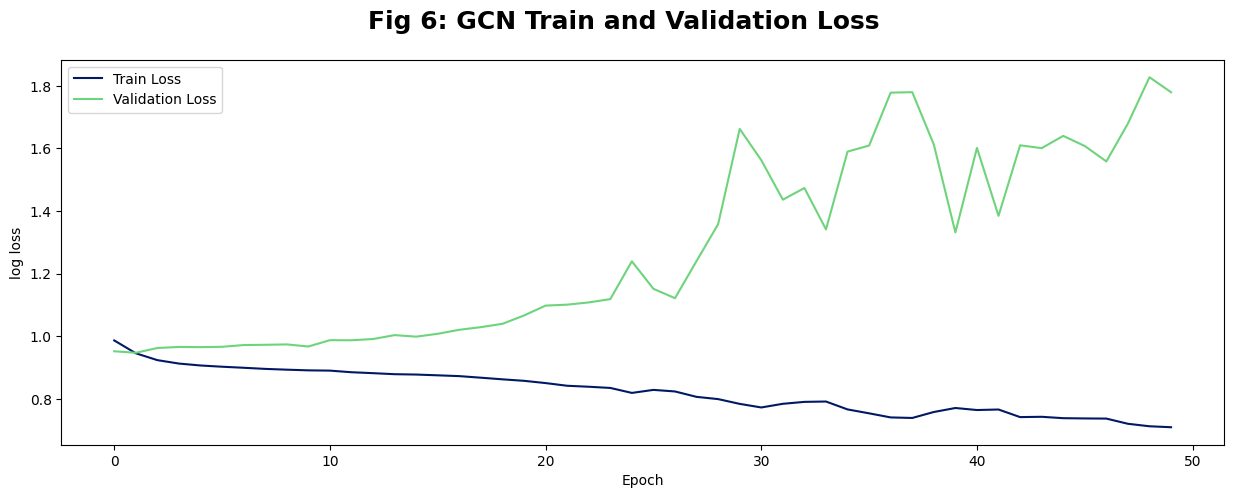

In [ ]:
gcn_train_loss_history = GCNTrainer.loss_history
gcn_val_loss_history = GCNTrainer.val_loss_history

plot_loss_curve(gcn_train_loss_history, gcn_val_loss_history, c1 = blue, c2 = green, ylab = "log loss", title = "Fig 6: GCN Train and Validation Loss")

### **Making GCN predictions, Confusion Matrices and Computing Metrics**

In [ ]:
gcn_train_preds, gcn_test_preds, gcn_val_preds = map(GCNTrainer.predict, [train_dlist, test_dlist, val_dlist])                                 # Make predictions
gcn_train_preds_bool, gcn_test_preds_bool, gcn_val_preds_bool = map(binarize_predictions, [gcn_train_preds, gcn_test_preds, gcn_val_preds])    # Binarize predictions. Using the default cutoff, which is 0.5

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

In [ ]:
# Compute confusion matrices for all 3 sets
gcn_cfm_train = multilabel_confusion_matrix(y_train, gcn_train_preds_bool)
gcn_cfm_test = multilabel_confusion_matrix(y_test, gcn_test_preds_bool)
gcn_cfm_val = multilabel_confusion_matrix(y_val, gcn_val_preds_bool)

In [ ]:
# Compute Classification Metrics for all 3 sets
gcn_train_metric_df = compute_classification_metrics(y_true=y_train, y_pred= gcn_train_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 4: Torch GCN Metrics (Train)")
gcn_test_metric_df = compute_classification_metrics(y_true=y_test, y_pred=gcn_test_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 5: Torch GCN Metrics (Test)")
gcn_val_metric_df = compute_classification_metrics(y_true=y_val, y_pred=gcn_val_preds_bool, return_df=True, colnames=target_names, style = True, title = "Tbl. 6: Torch GCN Metrics (Validation)")

### **Looking at the GCN's Confusion Matrices**
The GCN's confusion matrices dont look too god. Even on the training set there are both many false positives and false negatives, depending on which class you are considering. The situation is similar for the test and validation sets. We can however see that ATAD5 and MMP have the best predictions, correlating with the fact that they have the most positive examples of toxicity in the dataset.

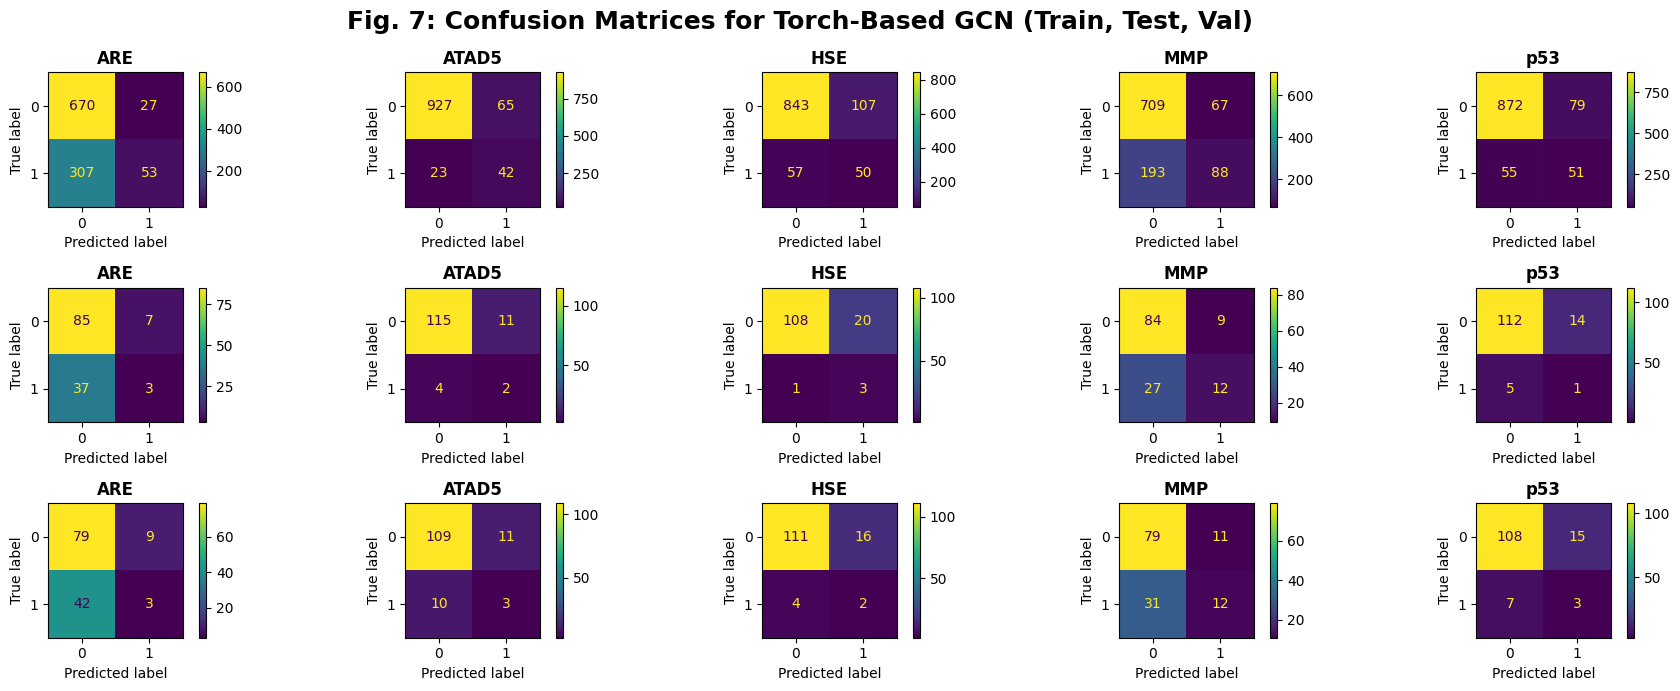

In [ ]:
plot_cfms(cfms = [gcn_cfm_train, gcn_cfm_test, gcn_cfm_val], class_names = target_names, suptitle = "Fig. 7: Confusion Matrices for Torch-Based GCN (Train, Test, Val)")

### **Looking at the Torch GCN's metrics**
The metrics confirm what could be seen in the confusion matrices. Performance measured by the precision/recall/f1 is mediocre at best on the various sets, but again better for MMP and ARE in terms of precision, and for ATAD5 in terms of recall.

In [ ]:
display_side_by_side([gcn_train_metric_df, gcn_test_metric_df, gcn_val_metric_df], tablespacing=25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.68,0.92,0.84,0.75,0.87
Precision,0.66,0.39,0.32,0.57,0.39
Recall,0.15,0.65,0.47,0.31,0.48
F1,0.24,0.49,0.38,0.40,0.43
Specificity,0.96,0.93,0.89,0.91,0.92
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.67,0.89,0.84,0.73,0.86
Precision,0.30,0.15,0.13,0.57,0.07
Recall,0.08,0.33,0.75,0.31,0.17
F1,0.12,0.21,0.22,0.40,0.10


Overall, the Torch-based GCN is performing particularly terrible. The precision, recall and f1 scores a pretty low on the train, test and validation sets, although there is a bit of variability depending on which class you look at specifically. Notice again that the accuracy and specificity have great scores, despite how bad the model is working, simply because the negative class is so overrepresented.

I've done a lot of hyperparameter tuning and couldn't find any consistently good parameters. Perhaps my featurization has not been extensive enough, or the features do not adequately describe the information needed to make good predictions. Nonetheless, the conclusion is that this specific model is pretty bad.

### **Comparing with DeepChems Graph Convolutinal Neural Net**

I have to admit defeat after hours of hyperparameter tuning, and conclude that the performance of my Torch-based GCN with my own calculated features is simply performing horribly. Here i will try to use DeepChem to do the convolutions instead. Here i re-do the train test validation splits and use the f1-score as the metric, as i argued earlier that this seemed like the most sensible metric for an imblanced dataset.

### **Training DeepChem GCN Model**

In [ ]:
dc_featurizer = dc.feat.ConvMolFeaturizer()
dataset_file = "./datasets/tox_processed.csv"

loader = dc.data.CSVLoader(
    tasks = task_names, feature_field = "smiles", featurizer = dc_featurizer
)

dc_dataset = loader.featurize(dataset_file, shard_size = 8192)

splitter = dc.splits.RandomSplitter()
dc_train_dataset, dc_valid_dataset, dc_test_dataset = splitter.train_valid_test_split(dc_dataset, seed = rand_state_of_choice)

/usr/local/lib/python3.10/dist-packages/deepchem/data/data_loader.py:161: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  warnings.warn(


In [ ]:
batch_size = 128
n_feat = 75

dc_model = dc.models.GraphConvModel(
              n_tasks,
              batch_size = batch_size,
              mode='classification',
              n_feat = n_feat,
              n_classes = 2,
              activation = "relu",
              dropout = 0.1,
              batchnorm = True,
              number_atom_features = n_feat
          )

n_epochs = 75
metric = dc.metrics.Metric(dc.metrics.f1_score, np.mean)
metric_string = "mean-f1_score"
dc_train_losses, dc_test_losses, dc_valid_losses = [], [], []

# Here i just train for one epoch at a time, for {n_epoch} epochs. Just so i can evaluate on the train, test and valid sets and save the losses to plot them later on.
for epoch in tqdm(range(n_epochs)):
  dc_model.fit(dc_train_dataset, nb_epoch=1)
  dc_train_loss = dc_model.evaluate(dc_train_dataset, [metric])[metric_string]
  dc_test_loss = dc_model.evaluate(dc_test_dataset, [metric])[metric_string]
  dc_valid_loss = dc_model.evaluate(dc_valid_dataset, [metric])[metric_string]

  dc_train_losses.append(dc_train_loss)
  dc_test_losses.append(dc_test_loss)
  dc_valid_losses.append(dc_valid_loss)

  0%|          | 0/75 [00:00<?, ?it/s]

### **Looking at the loss of the DC-model**
It's not strictly a loss curve that we are looking at now, but instead the f1-metric over the epochs. So now it should be going up rather than down, which it indeed does. However the model is still overfit to the training data, despite of trying to implement dropout between the convolutions.

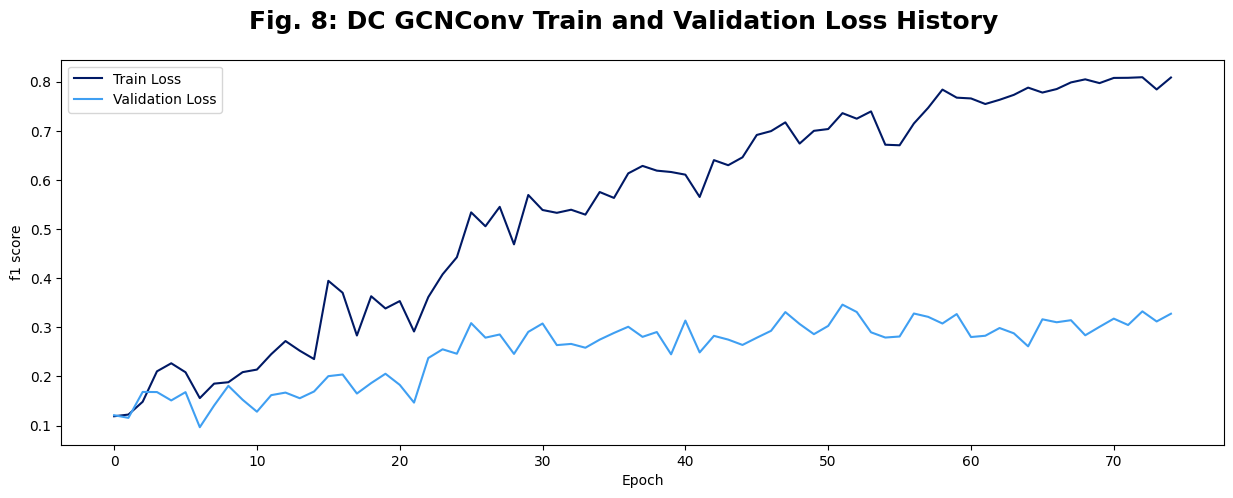

In [ ]:
plot_loss_curve(dc_train_losses, dc_valid_losses, c1 = blue, c2 = lightblue, title = "Fig. 8: DC GCNConv Train and Validation Loss History", ylab = "f1 score")

### **Code for the DC Confusion Matrices and Metrics**

In [ ]:
dc_y_train, dc_y_test, dc_y_valid = dc_train_dataset.y, dc_test_dataset.y, dc_valid_dataset.y

dc_train_preds, dc_test_preds, dc_valid_preds = map(dc_model.predict, (dc_train_dataset, dc_test_dataset, dc_valid_dataset))
dc_train_preds_binarized, dc_test_preds_binarized, dc_valid_preds_binarized = dc_train_preds.argmax(axis=-1), dc_test_preds.argmax(axis=-1), dc_valid_preds.argmax(axis=-1)

dc_train_f1, dc_test_f1, dc_valid_f1 = dc_model.evaluate(dc_train_dataset, [metric])[metric_string], dc_model.evaluate(dc_test_dataset, [metric])[metric_string], dc_model.evaluate(dc_valid_dataset, [metric])[metric_string]

dc_cfm_train = multilabel_confusion_matrix(dc_y_train, dc_train_preds_binarized)
dc_cfm_test = multilabel_confusion_matrix(dc_y_test, dc_test_preds_binarized)
dc_cfm_valid = multilabel_confusion_matrix(dc_y_valid, dc_valid_preds_binarized)

# Compute Classification Metrics for all 3 sets
dc_train_metric_df = compute_classification_metrics(y_true=dc_y_train, y_pred= dc_train_preds_binarized, return_df=True, colnames=target_names, style = True, title = "Tbl. 7: DC GCN Metrics (Train)")
dc_test_metric_df = compute_classification_metrics(y_true=dc_y_test, y_pred=dc_test_preds_binarized, return_df=True, colnames=target_names, style = True, title = "Tbl. 8: DC GCN Metrics (Test)")
dc_val_metric_df = compute_classification_metrics(y_true=dc_y_valid, y_pred=dc_valid_preds_binarized, return_df=True, colnames=target_names, style = True, title = "Tbl. 9: DC GCN Metrics (Validation)")

### **Looking at plots for the DC confusion matrices and metrics**
Plotting the confusion matrices and metrics for the DC-model, it looks quite a bit better than the one with PyTorch. At least for the training set, the model is performing quite well. But it is still not great. We have to look at the metrics to be sure.

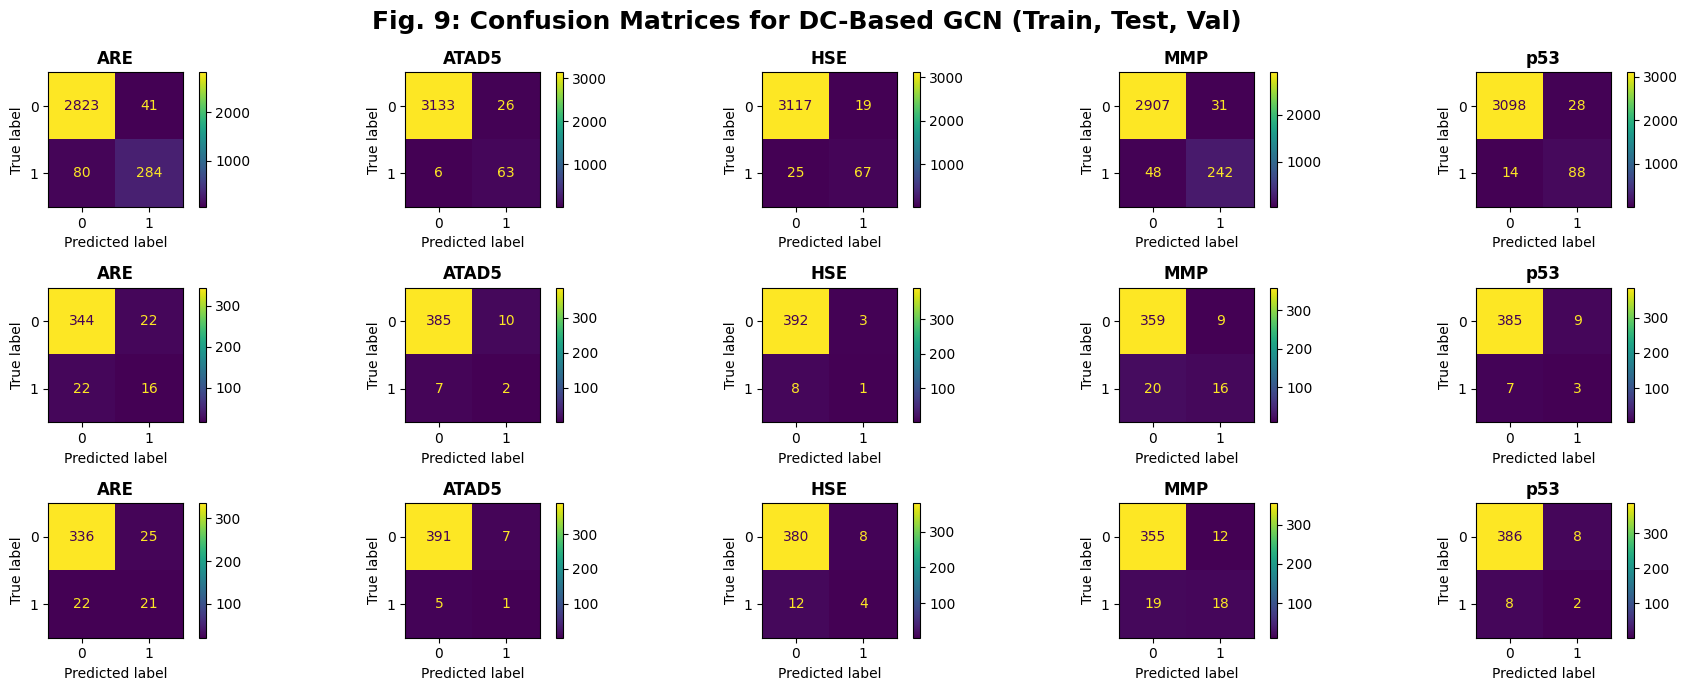

In [ ]:
plot_cfms(cfms = [dc_cfm_train, dc_cfm_test, dc_cfm_valid], class_names = target_names, suptitle = "Fig. 9: Confusion Matrices for DC-Based GCN (Train, Test, Val)")

Looking at the metrics it looks splendid for the test-set. But for the test and validation sets the metrics again aren't great. This is a great example of overfitting, that was hard to diminish with dropout which was added into the deepchem model. Again, at least MMP has decent metrics in terms of the F1 scores, and p53, ATAD5 have as well on the test and validation sets. There ended being no positive classes predicted for HSE, hence the value of precision/recall/f1 becomes 0 in the test set. The metrics for HSE are also the lowest in the training and validation set.

In [ ]:
display_side_by_side([dc_train_metric_df, dc_test_metric_df, dc_val_metric_df], tablespacing=25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.96,0.99,0.99,0.98,0.99
Precision,0.87,0.71,0.78,0.89,0.76
Recall,0.78,0.91,0.73,0.83,0.86
F1,0.82,0.80,0.75,0.86,0.81
Specificity,0.99,0.99,0.99,0.99,0.99
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.89,0.96,0.97,0.93,0.96
Precision,0.42,0.17,0.25,0.64,0.25
Recall,0.42,0.22,0.11,0.44,0.30
F1,0.42,0.19,0.15,0.52,0.27


## **Comparison with Null-Model**
Now let's compare the GCN and DNN with a naive model that simply predicts 0 for all labels.

### **Code for null-predictions**

In [ ]:
%%capture

null_train_preds = torch.zeros(gcn_train_preds.shape)
null_val_preds = torch.zeros(gcn_val_preds.shape)
null_test_preds = torch.zeros(gcn_test_preds.shape)

null_cfm_train = multilabel_confusion_matrix(y_train, null_train_preds)
null_cfm_test = multilabel_confusion_matrix(y_test, null_test_preds)
null_cfm_val = multilabel_confusion_matrix(y_val, null_val_preds)

null_train_metric_df = compute_classification_metrics(y_true=y_train, y_pred= null_train_preds, return_df=True, colnames=target_names, style = True, title = "Tbl. 10: Null Model Metrics (Train)")
null_test_metric_df = compute_classification_metrics(y_true=y_test, y_pred=null_test_preds, return_df=True, colnames=target_names, style = True, title = "Tbl. 11: Null Model Metrics (Test)")
null_val_metric_df = compute_classification_metrics(y_true=y_val, y_pred=null_val_preds, return_df=True, colnames=target_names, style = True, title = "Tbl. 12: Null Model Metrics (Validation)")

### **Plots for null-predictions**

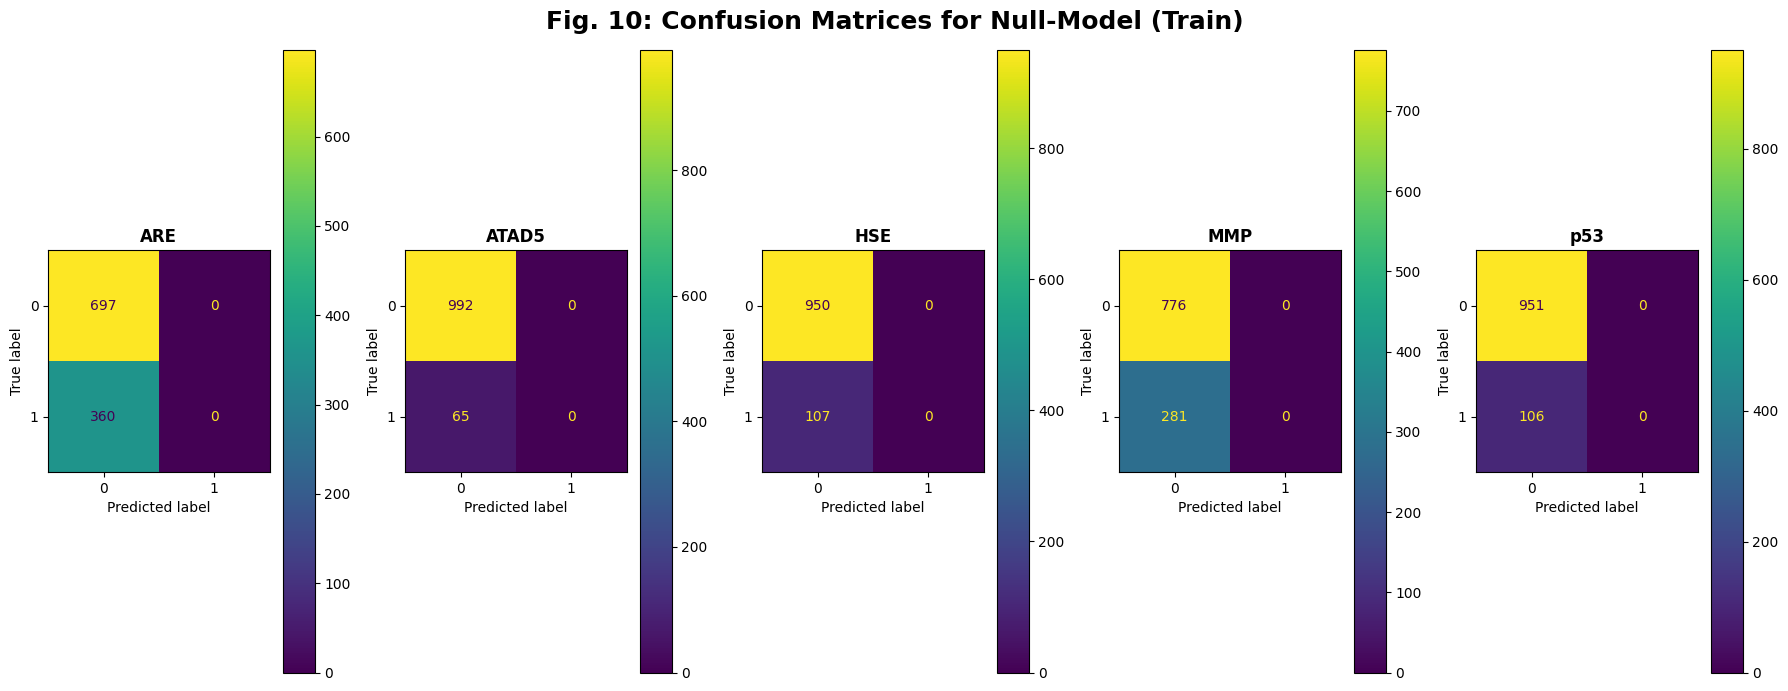

In [ ]:
plot_cfms(cfms = [null_cfm_train], class_names = target_names, suptitle = "Fig. 10: Confusion Matrices for Null-Model (Train)")

For all classes, (though slightly less for ARE that has the most positive instances) the true negatives highly outweight the false negatives, leading to a high accuracy and specificity, even though the model is not guessing intelligently. This is a symptom of the imbalanced data.

In [ ]:
display_side_by_side([null_train_metric_df, null_test_metric_df, null_val_metric_df], tablespacing=25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.66,0.94,0.90,0.73,0.90
Precision,0.00,0.00,0.00,0.00,0.00
Recall,0.00,0.00,0.00,0.00,0.00
F1,0.00,0.00,0.00,0.00,0.00
Specificity,1.00,1.00,1.00,1.00,1.00
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.70,0.95,0.97,0.70,0.95
Precision,0.00,0.00,0.00,0.00,0.00
Recall,0.00,0.00,0.00,0.00,0.00
F1,0.00,0.00,0.00,0.00,0.00


The calculated metrics for the null-model further reinforces my earlier statement that the accuracy and specificity are bad metrics for this particular dataset due to the heavy class imbalance. Notice that the precision can not be calculated due to divison by zero (there are no true or false positives) and that the recall is zero, because there are no true positives. For that reason the F1-score also becomes zero. If we were only to look at the accuracy and specificity, we might be fooled to think that this classifier is doing a good job, when it really is not.


## **Conclusion**

In this report, a dataset of molecules and their biological activities was cleaned, processed and used to train both a deep neural network and a graph convolutional neural network. For the DNN, the molecules were featurized with molecular fingerprints and descriptors, and for the GCN using a broad variety of atom-level features.

The preprocessing showed that it is important to thoroughly look through the molecules encoded by SMILES before proceeding to training the model, as SMILES-string that are not directly compatible with the model (such as complexes) or molecules that encode superfluous information (such as the molecules with the many waters encoded) might be found. It also showed that it's important to consider the implications of processing the molecules in a certain way, and to balance the risk of contaminating the dataset, with the risk of losing valuable data.

In the preliminary data analysis i showed that the dataset is subject to heavy class imbalance, both when looking at the data as a whole and when considering the data from the viewpoint of the single class, and that this can indeed be problematic for training the classifier. I also showed that this can to some degree be dealt with by undersampling the majority class, as well as assigning a larger weight in the loss function to the minority class.

The obtained metrics achieved on the training and validation sets of the different models, as well as a null model that simply predicts 0 are shown below.


In [ ]:
display_side_by_side([dnn_train_metric_df, gcn_train_metric_df, dc_train_metric_df, null_train_metric_df], tablespacing=25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.96,1.00,0.99,1.00,0.99
Precision,0.93,0.94,0.91,0.98,0.94
Recall,0.96,1.00,1.00,1.00,1.00
F1,0.95,0.97,0.95,0.99,0.97
Specificity,0.96,1.00,0.99,0.99,0.99
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.68,0.92,0.84,0.75,0.87
Precision,0.66,0.39,0.32,0.57,0.39
Recall,0.15,0.65,0.47,0.31,0.48
F1,0.24,0.49,0.38,0.40,0.43


In [ ]:
display_side_by_side([dnn_val_metric_df, gcn_val_metric_df, dc_val_metric_df, null_val_metric_df], tablespacing=25)

,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.65,0.92,0.86,0.74,0.89
Precision,0.49,0.58,0.07,0.60,0.33
Recall,0.58,0.54,0.17,0.60,0.40
F1,0.53,0.56,0.10,0.60,0.36
Specificity,0.69,0.96,0.89,0.81,0.93
,ARE,ATAD5,HSE,MMP,p53
Accuracy,0.62,0.84,0.85,0.68,0.83
Precision,0.25,0.21,0.11,0.52,0.17
Recall,0.07,0.23,0.33,0.28,0.30
F1,0.11,0.22,0.17,0.36,0.21


From these metrics we can conclude a few things. First we can see that the accuracy and specificity are meaningless metrics when training on a highly imbalanced dataset. The null model has great accuracy and specificity, and thoose for the random-guesser are statistically likely to be decent too. For this task, a metric that doesn't get skewed by the statistically probable high amount of true negatives is more appropriate, and the F1-score that incorporates the precision and recall into one measure is a good example.

Back in figure 3. i also showed that the F1-score is consistently better for ARE and MMP across 20 random train-test-val split, and this correlates with them being the most well-represented in terms of positive instances in the dataset. This goes to show that the molecules and chemical features that are not well represented in the dataset, are unlikely to be incorporated into the model, allowing for good predictions. This reinforces that sufficient data is very important, and that having too little informative data makes it very challenging to train a model.

The DNN trained on fingerprints seemeed to work the best on this dataset, when judged by the F1-scores, pretty consistently outperforming both the Torch and DeepChem based GCN. This doesn't mean that the DNN is necessarily better in this application or all others. It could also be that the features i chose for my own torch-based GCN were not informative enough, or that the hyperparameters i went through were just unlucky or badly chosen. When we consider how complex the thing we are asking the neural nets to model is, it could also be the case that the models need to be way more complex than what i can reasonably run in colab (and have patience to wait for training of). After all, there are thousands of cellular pathways, interactions with various macromolecules and chemical reactions that could be responsible for inducing these stress-response pathways in living cells, and expecting a relatively small neural net to model that effectively might be a bit ambitious.

It could also be worth to discuss whether it is even the right thing to think of toxicitiy as a binary classification task, as things are seldom binary in cell biology. There exist some threshold for the reporter assays at which the people behind this dataset have classified the molecules as toxic or non-toxic. Perhaps a molecule that induces a considerable level of cellular stress, but not enough to get flagged as toxic, will have some of the same features as a molecule that is labeled as 'fully' toxic but the model still has to somehow discern between whether those features are prominent enough to get somewhat arbitrarily labelled as toxic. Perhaps having the quantitative measures of fluorescence from the reporter assays would yield a better regression-based model, and then you could post-hoc determine at which threshold you would discern between a toxic and non-toxic molecule.

On a final note, the underlying data distribution makes this dataset particularly hard to work with and while i did not manage to get especially good metrics on the models, i hope that i have showed quantitatively why the models are at best mediocre and which metrics that are the right ones to conclude that.